# Load data

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1' # This will force CUDA to report errors immediately when they happen, giving you the correct line number.
import numpy as np 
import pandas as pd
import pickle
import networkx as nx
import dgl
import torch
import re
import random

Hyper parameters 

In [2]:
R_STATE = None
KNN = 10
METRIC = 'cosine' 

step 1: load H group, sample N group, combine for V_total group.

# Graph Functions

graph functions

In [28]:
import logging
def connect_gpu():

    GPU_DEVICE = 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if device.type == "cpu":
        logging.warning("CUDA is not available, using CPU for training.")
    else:
        # Print available devices
        num_devices = torch.cuda.device_count()
        logging.info(f"CUDA is available. Number of devices: {num_devices}")
        print(f"CUDA is available. Number of devices: {num_devices}")

        # Try connecting to the specific device
        try:
            torch.cuda.set_device(GPU_DEVICE)  # SET GPU INDEX HERE:
            current_device = torch.cuda.current_device()
            device_name = torch.cuda.get_device_name(current_device)
            logging.info(f"Using GPU device {current_device}: {device_name}")
            print(f"Using GPU device {current_device}: {device_name}")
        except Exception as e:
            logging.error(f"Failed to connect to GPU: {e}")
            device = torch.device("cpu")
    return device

device = connect_gpu()

CUDA is available. Number of devices: 2
Using GPU device 1: NVIDIA A100 80GB PCIe


In [4]:
def intersection_graph_with_weights(G1, G2, attr1='weight', attr2='weight', new_attr1='fast_weight', new_attr2='slow_weight'):
    """
    Returns a new graph with only edges present in both G1 and G2.
    Edge attributes from G1 and G2 are preserved as new_attr1 and new_attr2.
    Only nodes with at least one shared edge will be included.
    """
    G_inter = nx.Graph()
    # Create sets of edges as (nodeA, nodeB) sorted tuples for undirected comparison
    edges1 = set(tuple(sorted(e)) for e in G1.edges())
    edges2 = set(tuple(sorted(e)) for e in G2.edges())
    shared_edges = edges1 & edges2
    
    for u, v in shared_edges:
        # Copy correlation weights from both graphs
        w1 = G1[u][v][attr1]
        w2 = G2[u][v][attr2]
        G_inter.add_edge(u, v, **{new_attr1: w1, new_attr2: w2})
    return G_inter


def largest_component_size(G):
    if G.number_of_nodes() == 0:
        return 0
    return max(len(c) for c in nx.connected_components(G))

def tune_overlap_graph(
    fast_corr, slow_corr, 
    target_size=80, 
    init_min_r_fast=None, 
    init_min_r_slow=None,
    step=0.01, 
    max_iter=30, 
    tol=5, 
    verbose=True
):
    # Estimate good starting thresholds if not given
    if init_min_r_fast is None:
        fast_vals = fast_corr.values[np.triu_indices_from(fast_corr, k=1)]
        init_min_r_fast = np.percentile(fast_vals, 99)  # or adjust
    if init_min_r_slow is None:
        slow_vals = slow_corr.values[np.triu_indices_from(slow_corr, k=1)]
        init_min_r_slow = np.percentile(slow_vals, 99)
        
    min_r_fast = init_min_r_fast
    min_r_slow = init_min_r_slow
    best_diff = float('inf')
    best_result = None
    
    for i in range(max_iter):
        # Build graphs
        G_fast = build_pos_corr_graph_faster(fast_corr, min_r_fast)
        G_slow = build_pos_corr_graph_faster(slow_corr, min_r_slow)
        # Intersect
        G_overlap = intersection_graph_with_weights(G_fast, G_slow)
        # Largest component size
        lcc_size = largest_component_size(G_overlap)
        diff = abs(lcc_size - target_size)
        if verbose:
            print(f"Iter {i}: min_r_fast={min_r_fast:.4f}, min_r_slow={min_r_slow:.4f}, "
                  f"LCC size={lcc_size}, nodes={G_overlap.number_of_nodes()}, edges={G_overlap.number_of_edges()}")
        # Save best result so far
        if diff < best_diff:
            best_diff = diff
            best_result = (min_r_fast, min_r_slow, G_fast, G_slow, G_overlap, lcc_size)
        # Converged?
        if diff <= tol:
            break
        # Adjust thresholds:
        if lcc_size > target_size:
            # Too big: increase thresholds
            min_r_fast += step
            min_r_slow += step
        else:
            # Too small: decrease thresholds
            min_r_fast -= step
            min_r_slow -= step
    # Return best result
    return {
        "min_r_fast": best_result[0],
        "min_r_slow": best_result[1],
        "G_fast": best_result[2],
        "G_slow": best_result[3],
        "G_overlap": best_result[4],
        "lcc_size": best_result[5]
    }

def build_pos_corr_graph_faster(corr_matrix, min_r=None):
    """
    Efficiently build a NetworkX graph from a correlation matrix using a threshold.
    Precompute the edge list directly from the correlation matrix (using NumPy or pandas).
    Only adds edges where r >= min_r (positive correlation).
    """
    tcrs = np.array(corr_matrix.index)
    # Get upper triangle indices (excluding diagonal)
    mask = np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1)
    # Get pairs and correlations
    i_idx, j_idx = np.where(mask)
    corrs = corr_matrix.values[mask]
    if min_r is not None:
        select = np.where(corrs >= min_r)[0]
        i_idx = i_idx[select]
        j_idx = j_idx[select]
        corrs = corrs[select]
    # Build edge list
    edge_list = [
        (tcrs[i], tcrs[j], {'weight': float(corr)})
        for i, j, corr in zip(i_idx, j_idx, corrs)
    ]
    # Create graph
    G = nx.Graph()
    G.add_edges_from(edge_list)
    return G

import pickle

# Save function
def save_graph(graph, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graph, f)

# Load function
def load_graph(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [5]:
def load_clonotype():
    mixcr_dir = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/new_mixcr/TRB/"
    meta_file = "/home/dsi/orrbavly/GNN_project/data/colon_meta_time.csv"

    time_threshold = 750
    meta_df = pd.read_csv(meta_file)
    meta_df = meta_df[["Sample_ID", "extraction_time"]]

    # Columns to keep from MiXCR files
    mixcr_cols = [
        "aaSeqCDR3", "nSeqCDR3", "readCount", 'readFraction',
        "allVHitsWithScore", "allDHitsWithScore", "allJHitsWithScore"
    ]
    clonotype_dfs = []

    for fname in os.listdir(mixcr_dir):
        if fname.endswith(".tsv") and os.path.isfile(os.path.join(mixcr_dir, fname)):
            sample_prefix = fname.split("_")[0]
            file_path = os.path.join(mixcr_dir, fname)
            
            df = pd.read_csv(file_path, sep="\t", usecols=mixcr_cols)
            df["Sample_ID"] = sample_prefix
            clonotype_dfs.append(df)

    clonotype_df = pd.concat(clonotype_dfs, ignore_index=True)

    # Merge with metadata to get extraction time
    clonotype_df = clonotype_df.merge(meta_df, on="Sample_ID", how="inner")
    # Create 'group' column: fast vs slow
    clonotype_df["group"] = clonotype_df["extraction_time"].apply(lambda x: "fast" if x <= time_threshold else "slow")
    return clonotype_df

def load_corr(clonotype_df, threshold=5,):
    # A narrow view ONLY for the survivor/qualification logic
    logic_df = clonotype_df[['Sample_ID','group','aaSeqCDR3']].dropna(subset=['aaSeqCDR3','group'])
    # 1) survivors: AA present in BOTH groups
    presence = (logic_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
                        .size().unstack(fill_value=0))
    survivors = presence.index[(presence.get('fast',0) > 0) & (presence.get('slow',0) > 0)]
    survivor_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(survivors)].copy()  # keeps ALL columns

    threshold = threshold
    counts = (survivor_df.groupby(['aaSeqCDR3','group'])['Sample_ID']
            .nunique().unstack(fill_value=0))
    qualified_tcrs = counts[(counts.get('fast',0) >= threshold) &
                            (counts.get('slow',0) >= threshold)].index

    # === keep these objects with ALL columns ===
    qualified_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(qualified_tcrs)].copy()

    fast_df = qualified_df[qualified_df['group'] == 'fast'].copy()
    slow_df = qualified_df[qualified_df['group'] == 'slow'].copy()

    # Expression matrices (needs 'readFraction' present in sub)
    fast_expr = fast_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)
    slow_expr = slow_df.pivot_table(index='aaSeqCDR3', columns='Sample_ID',
                                    values='readFraction', fill_value=0)

    fast_expr_numpy = fast_expr.to_numpy()
    fast_corr_numpy = np.corrcoef(fast_expr_numpy)
    fast_corr = pd.DataFrame(fast_corr_numpy, index=fast_expr.index, columns=fast_expr.index)

    slow_expr_numpy = slow_expr.to_numpy()
    slow_corr_numpy = np.corrcoef(slow_expr_numpy)
    slow_corr = pd.DataFrame(slow_corr_numpy, index=slow_expr.index, columns=slow_expr.index)
    return fast_df, slow_df, fast_corr, slow_corr

def create_tcr_meta_for_gnn(tcr_sequences, fast_df, slow_df):
    """
    Build per-sequence V/J annotations for fast/slow groups, plus sample_prevalence
    and codon_diversity, and map V/J to categorical IDs.

    Parameters
    ----------
    tcr_sequences : list[str]
        List of amino-acid CDR3 sequences.

    Returns
    -------
    pd.DataFrame
        Columns:
            cdr3_sequence,
            V_gene_fast,  V_gene_fast_id,
            J_gene_fast,  J_gene_fast_id,
            sample_prevalence_fast, codon_diversity_fast,
            V_gene_slow,  V_gene_slow_id,
            J_gene_slow,  J_gene_slow_id,
            sample_prevalence_slow, codon_diversity_slow
    """
    def clean_vj(gene_str):
        return re.sub(r"\*.*", "", gene_str) if isinstance(gene_str, str) else gene_str

    def mode_or_na(s):
        m = s.mode()
        return m.iat[0] if not m.empty else pd.NA

    # --- per-group V/J + prevalence/diversity maps ---
    vj_map_fast = (
        fast_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,     # codon diversity
            "Sample_ID": pd.Series.nunique     # sample prevalence
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_fast",
            "allJHitsWithScore": "J_gene_fast",
            "nSeqCDR3": "codon_diversity_fast",
            "Sample_ID": "sample_prevalence_fast"
        })
    )

    vj_map_slow = (
        slow_df.groupby("aaSeqCDR3")
        .agg({
            "allVHitsWithScore": mode_or_na,
            "allJHitsWithScore": mode_or_na,
            "nSeqCDR3": pd.Series.nunique,
            "Sample_ID": pd.Series.nunique
        })
        .rename(columns={
            "allVHitsWithScore": "V_gene_slow",
            "allJHitsWithScore": "J_gene_slow",
            "nSeqCDR3": "codon_diversity_slow",
            "Sample_ID": "sample_prevalence_slow"
        })
    )
    # Clean allele fields
    for col in ("V_gene_fast", "J_gene_fast"):
        if col in vj_map_fast:
            vj_map_fast[col] = vj_map_fast[col].apply(clean_vj)
    for col in ("V_gene_slow", "J_gene_slow"):
        if col in vj_map_slow:
            vj_map_slow[col] = vj_map_slow[col].apply(clean_vj)

    # --- base df from sequences ---
    out = pd.DataFrame({"cdr3_sequence": list(tcr_sequences)})
    # merge annotations
    out = (
        out
        .merge(vj_map_fast, how="left", left_on="cdr3_sequence", right_index=True)
        .merge(vj_map_slow, how="left", left_on="cdr3_sequence", right_index=True)
    )
    # --- categorical IDs from combined vocab ---
    v_vocab = pd.unique(
        pd.concat([out["V_gene_fast"], out["V_gene_slow"]], ignore_index=True).dropna()
    )
    v_gene_to_id = {v: i for i, v in enumerate(sorted(set(v_vocab)))}

    j_vocab = pd.unique(
        pd.concat([out["J_gene_fast"], out["J_gene_slow"]], ignore_index=True).dropna()
    )
    j_gene_to_id = {j: i for i, j in enumerate(sorted(set(j_vocab)))}

    out["V_gene_fast_id"] = out["V_gene_fast"].map(v_gene_to_id)
    out["V_gene_slow_id"] = out["V_gene_slow"].map(v_gene_to_id)
    out["J_gene_fast_id"] = out["J_gene_fast"].map(j_gene_to_id)
    out["J_gene_slow_id"] = out["J_gene_slow"].map(j_gene_to_id)
    # final column order
    out = out[[
        "cdr3_sequence",
        "V_gene_fast", "V_gene_fast_id",
        "J_gene_fast", "J_gene_fast_id",
        "sample_prevalence_fast", "codon_diversity_fast",
        "V_gene_slow", "V_gene_slow_id",
        "J_gene_slow", "J_gene_slow_id",
        "sample_prevalence_slow", "codon_diversity_slow",
    ]]

    return out


def sample_random_controls_simple(fast_df, slow_df, h_tcrs, n=None, random_state=0):
    """
    Simple control sampler:
      - uses fast_df/slow_df you've already qualified
      - keeps only TCRs present in BOTH groups
      - excludes the provided H set
      - uniformly samples n controls (default: len(H))
    """
    # unique CDR3s per group
    fast_set = set(fast_df['aaSeqCDR3'].dropna().unique())
    slow_set = set(slow_df['aaSeqCDR3'].dropna().unique())
    both = fast_set & slow_set

    # exclude H
    h_set = set(h_tcrs)
    eligible = list(both - h_set)
    if n is None:
        n = len(h_set)
    if n > len(eligible):
        raise ValueError(f"Requested {n} controls but only {len(eligible)} eligible after excluding H.")

    rng = np.random.default_rng(random_state)
    r_group = rng.choice(eligible, size=n, replace=False).tolist()

    # return the pool (optional, handy for debugging or later matching)
    pool_df = pd.DataFrame({'aaSeqCDR3': eligible})
    return r_group, pool_df

    

In [6]:
def create_v_group(fast_r, slow_r, sample_threshold, clonotype_df,r_size=None):
    # r_size = how many multipications of h_group
    print("Loading corrolation...")
    fast_df, slow_df, fast_corr, slow_corr = load_corr(clonotype_df, threshold=sample_threshold)
    print("Loading graph...")
    G_fast_sub = build_pos_corr_graph_faster(fast_corr, min_r=fast_r)
    G_slow_sub = build_pos_corr_graph_faster(slow_corr, min_r=slow_r)
    G_overlap = intersection_graph_with_weights(G_fast_sub, G_slow_sub)
    print("Creating V,R groups...")
    H_group = list(G_overlap.nodes())
    # Sampling R group using filtered fast/slow_df, ensures no Publicity bias between H & R group.
    if r_size is None:
        # for 1:1 V total group
        r_group_size= len(H_group)
    else:
        # for unbalanced V total group
        r_group_size= r_size * len(H_group)
    R_group, _ = sample_random_controls_simple(fast_df, slow_df, H_group,
            n=r_group_size, random_state=R_STATE)
    V_group = H_group + R_group
    V_total_df = pd.DataFrame({
        'cdr3_seq': H_group + R_group,
        'label': [1] * len(H_group) + [0] * len(R_group)
    })
    meta_df = create_tcr_meta_for_gnn(V_total_df['cdr3_seq'].tolist(), fast_df, slow_df)
    # Merge metadata back into the labeled DataFrame
    V_total_df = (
        V_total_df
        .merge(meta_df, left_on='cdr3_seq', right_on='cdr3_sequence', how='left')
        .drop(columns='cdr3_sequence')  # optional cleanup; we already have 'cdr3_seq'
    )
    return V_total_df


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl.nn.pytorch import GINConv

class GINNodeClassifier(nn.Module):
    def __init__(self, 
                 # 1. Dims for continuous features
                 continuous_dim,        # This will be 778
                 
                 # 2. Dims for categorical features
                 # We need the *number of unique categories* for each
                 num_v_fast,            # e.g., V_total_df['v_gene_fast_id'].max() + 1
                 num_j_fast,            # e.g., V_total_df['j_gene_fast_id'].max() + 1
                 num_v_slow,
                 num_j_slow,
                 
                 # 3. Model hyperparameters
                 hidden_dim,            # The main hidden dimension (e.g., 128)
                 embed_dim,             # Dim for each gene embedding (e.g., 16)
                 n_gin_layers,          # Number of GIN layers (e.g., 2 or 3)
                 dropout: float,
                 n_classes):            # Output dim (this is 2: Label 0 vs 1)
        
        super(GINNodeClassifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # --- A. Feature Processing Layers ---
        
        # 1. Embedding layers for our 4 categorical gene features
        # Each will learn a "lookup table" for its gene IDs
        self.v_fast_embed = nn.Embedding(num_v_fast, embed_dim)
        self.j_fast_embed = nn.Embedding(num_j_fast, embed_dim)
        self.v_slow_embed = nn.Embedding(num_v_slow, embed_dim)
        self.j_slow_embed = nn.Embedding(num_j_slow, embed_dim)
        
        # 2. A simple MLP to process the 778 continuous features
        # This will normalize them and project them to our hidden_dim
        self.continuous_mlp = nn.Sequential(
            nn.Linear(continuous_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        
        # 3. A linear layer to project the 4 *combined* gene embeddings
        # Total dim will be (embed_dim * 4)
        self.categorical_linear = nn.Linear(embed_dim * 4, hidden_dim)

        # --- B. GIN Convolutional Layers ---
        
        # The *actual input* to our GIN layers will be the *sum* of the 
        # processed continuous and categorical features.
        self.gin_layers = nn.ModuleList()
        
        for _ in range(n_gin_layers):
            # The apply_func for GIN is a simple MLP
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim * 2),
                nn.ReLU(),
                nn.Linear(hidden_dim * 2, hidden_dim),
                nn.BatchNorm1d(hidden_dim)
            )
            self.gin_layers.append(GINConv(apply_func=mlp, aggregator_type='sum'))

        # --- C. Classifier Head ---
        # This takes the final node representations from the GIN layers
        # and makes the 2-class prediction
        self.classifier = nn.Linear(hidden_dim, n_classes)

    def forward(self, g, feat_continuous, feat_categorical):
        # g: our DGL graph
        # feat_continuous: g.ndata['feat_continuous']
        # feat_categorical: g.ndata['feat_categorical']
        
        # --- 1. Process Continuous Features ---
        h_cont = self.continuous_mlp(feat_continuous)
        
        # --- 2. Process Categorical Features ---
        # Get the IDs (shape [N, 4])
        v_fast_ids = feat_categorical[:, 0]
        j_fast_ids = feat_categorical[:, 1]
        v_slow_ids = feat_categorical[:, 2]
        j_slow_ids = feat_categorical[:, 3]
        
        # Embed them (shape [N, embed_dim] each)
        h_v_fast = self.v_fast_embed(v_fast_ids)
        h_j_fast = self.j_fast_embed(j_fast_ids)
        h_v_slow = self.v_slow_embed(v_slow_ids)
        h_j_slow = self.j_slow_embed(j_slow_ids)
        
        # Combine all 4 embeddings into one tensor (shape [N, embed_dim * 4])
        h_cat = torch.cat([h_v_fast, h_j_fast, h_v_slow, h_j_slow], dim=1)
        # Project them to match the continuous hidden_dim
        h_cat = self.categorical_linear(h_cat)
        
        # --- 3. Create Final Input 'h' ---
        # We add the two feature representations together
        h = h_cont + h_cat
        
        # --- 4. Pass through GIN Layers ---
        for layer in self.gin_layers:
            h = layer(g, h)
            h = F.relu(h)
            h = self.dropout(h)
            
        # --- 5. Get Final Predictions ---
        # h is now our final node representation (shape [N, hidden_dim])
        # Pass it to the classifier to get raw scores (logits)
        logits = self.classifier(h)
        
        # logits shape is [3994, 2]
        return logits

# Creating the Graph

extract h group, and sample r group.

In [8]:
clonotype_df = load_clonotype()

In [42]:
fast_df, slow_df, fast_corr, slow_corr = load_corr(clonotype_df, threshold=4)

tune_results = tune_overlap_graph(
    fast_corr, slow_corr,
    init_min_r_fast= 0.700, 
    init_min_r_slow= 0.720,
    target_size=10, # LCC target size
    step=0.005,    # Try 0.01 or smaller for fine control
    max_iter=40,
    tol=5,         # Acceptable range
    verbose=True
)
G_overlap = tune_results["G_overlap"]

Iter 0: min_r_fast=0.7000, min_r_slow=0.7200, LCC size=53, nodes=4445, edges=5402
Iter 1: min_r_fast=0.7050, min_r_slow=0.7250, LCC size=53, nodes=4223, edges=5119
Iter 2: min_r_fast=0.7100, min_r_slow=0.7300, LCC size=51, nodes=4018, edges=4859
Iter 3: min_r_fast=0.7150, min_r_slow=0.7350, LCC size=51, nodes=3809, edges=4605
Iter 4: min_r_fast=0.7200, min_r_slow=0.7400, LCC size=50, nodes=3598, edges=4340
Iter 5: min_r_fast=0.7250, min_r_slow=0.7450, LCC size=50, nodes=3402, edges=4110
Iter 6: min_r_fast=0.7300, min_r_slow=0.7500, LCC size=49, nodes=3191, edges=3856
Iter 7: min_r_fast=0.7350, min_r_slow=0.7550, LCC size=49, nodes=2987, edges=3628
Iter 8: min_r_fast=0.7400, min_r_slow=0.7600, LCC size=49, nodes=2828, edges=3432
Iter 9: min_r_fast=0.7450, min_r_slow=0.7650, LCC size=48, nodes=2643, edges=3217
Iter 10: min_r_fast=0.7500, min_r_slow=0.7700, LCC size=47, nodes=2498, edges=3042
Iter 11: min_r_fast=0.7550, min_r_slow=0.7750, LCC size=45, nodes=2371, edges=2858
Iter 12: min_r

KeyboardInterrupt: 

In [43]:
V_total_df = create_v_group(0.765, 0.785, 4, clonotype_df,r_size=5)

Loading corrolation...
Loading graph...
Creating V,R groups...


In [44]:
V_total_df = V_total_df.set_index('cdr3_seq', drop=False)
V_total_df = V_total_df.drop(columns=['Unnamed: 0'], errors='ignore')
V_total_df


,cdr3_seq,label,V_gene_fast,V_gene_fast_id,J_gene_fast,J_gene_fast_id,sample_prevalence_fast,codon_diversity_fast,V_gene_slow,V_gene_slow_id,J_gene_slow,J_gene_slow_id,sample_prevalence_slow,codon_diversity_slow
cdr3_seq,,,,,,,,,,,,,,
CASSLDFYNEQFF,CASSLDFYNEQFF,1,TRBV11-3,5,TRBJ2-1,6,24,15,TRBV11-2,4,TRBJ2-1,6,6,6
CASSLTAGANVLTF,CASSLTAGANVLTF,1,TRBV11-2,4,TRBJ2-6,11,34,24,TRBV11-2,4,TRBJ2-6,11,6,8
CASSSGLAGALDTQYF,CASSSGLAGALDTQYF,1,TRBV7-2,42,TRBJ2-3,8,4,4,TRBV5-1,31,TRBJ2-3,8,4,4
CASSSNRGNQPQHF,CASSSNRGNQPQHF,1,TRBV12-3,8,TRBJ1-5,4,17,14,TRBV12-3,8,TRBJ1-5,4,4,4
CASSLVQGATEAFF,CASSLVQGATEAFF,1,TRBV11-2,4,TRBJ1-1,0,16,12,TRBV28,24,TRBJ1-1,0,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CASSLGLSDTQYF,CASSLGLSDTQYF,0,TRBV11-2,4,TRBJ2-3,8,28,27,TRBV11-3,5,TRBJ2-3,8,9,9
CASSVSVNTEAFF,CASSVSVNTEAFF,0,TRBV10-1,0,TRBJ1-1,0,14,14,TRBV19,16,TRBJ1-1,0,4,5
CASSLRDGYEQYF,CASSLRDGYEQYF,0,TRBV12-3,8,TRBJ2-7,12,20,16,TRBV12-4,9,TRBJ2-7,12,4,5


In [45]:
# V_total_df.to_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_2115_4_765_785_1-5.csv")

In [34]:
embeddings_df = pd.read_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_embedded_v2.pkl")
V_total_df = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
V_total_df = V_total_df.set_index('cdr3_seq', drop=False)
V_total_df = V_total_df.drop(columns=['Unnamed: 0'], errors='ignore')


In [30]:
v_1 = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
v_2 = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_2025_5_695_715_1-5.csv")

In [48]:
import pandas as pd

# (Assuming V_total_df is loaded and has 'label' and prevalence columns)

# --- 1. Define the features we want to compare ---
features_to_compare = [
    'sample_prevalence_fast', 
    'sample_prevalence_slow'
]

# --- 2. Group by 'label' and calculate stats ---
# We'll get mean, median, std dev, min, and max to get a full picture
stats_df = v_1.groupby('label')[features_to_compare].agg(
    ['mean', 'median', 'std', 'min', 'max']
)

# --- 3. Print the comparison table ---
print("--- Publicity Feature Comparison (Label 0 vs. Label 1) ---")

print(stats_df.round(2))  # rounds for readability

--- Publicity Feature Comparison (Label 0 vs. Label 1) ---
      sample_prevalence_fast                        sample_prevalence_slow                     
                        mean median    std min  max                   mean median   std min max
label                                                                                          
0                      20.22   15.0  17.80   3  146                   5.09    4.0  3.56   3  44
1                      15.90   11.0  14.92   3  134                   4.38    3.0  2.72   3  32


Load embeddings, and calculate KNN using sklearn

In [89]:
from sklearn.neighbors import NearestNeighbors
embeddings = embeddings_df.iloc[:, 1:].values 
print(f"Loaded embeddings with shape: {embeddings.shape}") # (e.g., 4000, 764)

# --- Calculate k-NN ---
print(f"Calculating k-NN with k={KNN} and metric='{METRIC}'...")
# algorithm='brute' is often fastest for 'cosine' in high dims
nbrs = NearestNeighbors(n_neighbors=KNN, metric=METRIC,
                         algorithm='brute', n_jobs=-1)
nbrs.fit(embeddings)
# Find the k-neighbors for all 4000 nodes
# distances: (4000, K) array of distances, indices: (4000, K) array of node indices
distances, indices = nbrs.kneighbors(embeddings)

Loaded embeddings with shape: (3994, 768)
Calculating k-NN with k=10 and metric='cosine'...


Construct DGL graph object

In [90]:
N_total = len(V_total_df)
K = indices.shape[1]  

# --- Create Edge Lists ---
# We need two lists: source nodes (u) and destination nodes (v)
# Source nodes (u): [0, 0, ..., 1, 1, ..., 2, 2, ..., N-1, N-1]
# Every node 'i' is a source node K times.
u = torch.arange(N_total).repeat_interleave(K)

# Destination nodes (v): [n_0_0, n_0_1, ..., n_1_0, n_1_1, ...]
# This is just the flattened k-NN indices array.
v = torch.tensor(indices).flatten()

# --- Build the DGL Graph ---
print(f"Building DGL graph with {N_total} nodes and {len(u)} edges...")
g = dgl.graph((u, v), num_nodes=N_total)
# (Optional but Recommended) Add self-loops.This allows a node to use its *own* features in the GNN update step.
g = dgl.add_self_loop(g)

print(f"Graph built: {g}")

Building DGL graph with 3994 nodes and 39940 edges...
Graph built: Graph(num_nodes=3994, num_edges=43934,
      ndata_schemes={}
      edata_schemes={})


G edges are connectd via same V-gene-fast

In [ ]:
# n_nodes = len(V_total_df)
# # Get the V-gene ID for each node (using the node's index: 0 to 3993)
# # Fillna(0) ensures "missing" genes become their own community
# gene_ids = torch.tensor(V_total_df['V_gene_fast_id'].fillna(0).values, dtype=torch.long)

# # --- Build Edge Lists ---
# # This is a bit more complex, but we can do it efficiently
# # We are building a "clique" for each gene ID

# u_list = [] # Source nodes
# v_list = [] # Dest nodes

# # Group nodes by their gene ID
# for gene_id in torch.unique(gene_ids):
#     if gene_id == 0: # We can skip the "missing" group if we want
#         continue
    
#     # Get all nodes that belong to this V-gene community
#     community_nodes = torch.where(gene_ids == gene_id)[0]
    
#     # Create all-to-all connections (a clique) within this community
#     # This is a "Cartesian product" of the nodes with themselves
#     src = community_nodes.repeat_interleave(len(community_nodes))
#     dst = community_nodes.repeat(len(community_nodes))
    
#     u_list.append(src)
#     v_list.append(dst)

# # Combine all cliques into one set of edge lists
# u = torch.cat(u_list)
# v = torch.cat(v_list)

# # --- Build the DGL Graph ---
# print(f"Building V-Gene graph with {n_nodes} nodes...")
# g = dgl.graph((u, v), num_nodes=n_nodes)
# g = dgl.to_simple(g) # Remove duplicate edges and self-loops
# g = dgl.add_self_loop(g) # Add self-loops back in (important for GIN)

# print(f"Graph built: {g}")

Building V-Gene graph with 3994 nodes...


Graph built: Graph(num_nodes=3994, num_edges=2047952,
      ndata_schemes={}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)})


In [91]:
# Get labels from V_total_df
# We must ensure the order is correct (matches the node IDs 0 to 3993)
labels = torch.tensor(V_total_df['label'].values, dtype=torch.long)
g.ndata['label'] = labels

# Get the 4 gene ID columns. We'll fill NaNs with 0 (our "missing" ID)
cat_features_df = V_total_df[[
    'V_gene_fast_id', 'J_gene_fast_id', 
    'V_gene_slow_id', 'J_gene_slow_id'
]]
cat_features = torch.tensor(cat_features_df.fillna(0).values, dtype=torch.long)
g.ndata['feat_categorical'] = cat_features


In [92]:
features_list = []

# # --- Feature 1: CVC Embeddings ---
# embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32) # convert from np to torch tensor
# features_list.append(embeddings_tensor)

# --- Feature 2: Graph-based Features ---
# We calculate these directly from our new graph 'g'
g_in_degrees = g.in_degrees().float().unsqueeze(1)
g_out_degrees = g.out_degrees().float().unsqueeze(1)
features_list.append(g_in_degrees)
features_list.append(g_out_degrees)

# --- Feature 3: Diversity & Prevalence Features ---
# We get these directly from V_total_df
div_prev_features_df = V_total_df[[
    'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow'
]]
# Fill NaNs with 0 before converting to tensor
div_prev_features = torch.tensor(div_prev_features_df.fillna(0).values, dtype=torch.float32)
features_list.append(div_prev_features)

In [93]:
# --- Feature 4: Aggregated Expression Features ---
# We calculate these from the all_samples_df
# Build a clean set of keys from V_total_df (robust to dupes/NaNs)
tcr_keys = (
    V_total_df['cdr3_seq'].dropna().astype(str).unique())   # use the column (same values as the index in your case)
# Filter clonotype_df by aaSeqCDR3
expression_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_keys)]# 2. Group by TCR and get aggregated stats (e.g., mean, median, std)
# Group by the correct key
agg_expr_df = expression_df.groupby('aaSeqCDR3')['readFraction'].agg(['mean', 'std', 'median', 'max'])
# Re-order to match V_total_df's node order
agg_expr_df = agg_expr_df.reindex(V_total_df['cdr3_seq'].values) 

agg_expr_tensor = torch.tensor(agg_expr_df.fillna(0).values, dtype=torch.float32)
features_list.append(agg_expr_tensor)

# --- Final Step: Stack all continuous features ---
# This will now work, as features_list contains only Tensors
continuous_features = torch.cat(features_list, dim=1)
g.ndata['feat_continuous'] = continuous_features

print(f"Graph features assembled:")
print(g)
print(f"Continuous features shape: {g.ndata['feat_continuous'].shape}")

Graph features assembled:
Graph(num_nodes=3994, num_edges=43934,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat_categorical': Scheme(shape=(4,), dtype=torch.int64), 'feat_continuous': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={})
Continuous features shape: torch.Size([3994, 10])


# GNN Training

In [61]:
import torch.nn.functional as F

# --- A. Create Masks ---
# We'll split our 3994 nodes into 60% train, 20% val, 20% test
n_nodes = g.num_nodes()
node_indices = torch.randperm(n_nodes) # Shuffle the node IDs

n_train = int(n_nodes * 0.6)
n_val = int(n_nodes * 0.2)
# n_test is the remainder

train_indices = node_indices[:n_train]
val_indices = node_indices[n_train : n_train + n_val]
test_indices = node_indices[n_train + n_val :]

# Create boolean masks
train_mask = torch.zeros(n_nodes, dtype=torch.bool)
val_mask = torch.zeros(n_nodes, dtype=torch.bool)
test_mask = torch.zeros(n_nodes, dtype=torch.bool)

train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# Now we can add the masks (which are still on the CPU)
# DGL handles this by copying them to the GPU automatically
g.ndata['train_mask'] = train_mask
g.ndata['val_mask'] = val_mask
g.ndata['test_mask'] = test_mask

# --- B. Move Graph to GPU ---
# This moves the graph structure AND all ndata 
# ('label', 'feat_continuous', 'feat_categorical') to the GPU at once.
g_gpu = g.to(device)


In [62]:
# --- B. Instantiate Model ---
# We need to get the "max_id + 1" for our categorical embedding dimensions
cat_feats = g_gpu.ndata['feat_categorical']

model = GINNodeClassifier(
    continuous_dim=g_gpu.ndata['feat_continuous'].shape[1], # 778
    
    num_v_fast=cat_feats[:, 0].max().item() + 1,
    num_j_fast=cat_feats[:, 1].max().item() + 1,
    num_v_slow=cat_feats[:, 2].max().item() + 1,
    num_j_slow=cat_feats[:, 3].max().item() + 1,
    
    hidden_dim=32,  
    embed_dim=16,    
    n_gin_layers=2,
    dropout=0.6,  
    n_classes=2      
).to(device)

# --- C. Define Loss and Optimizer ---
# CrossEntropyLoss is standard for multi-class classification (it handles 2 classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

# --- D. Training Loop ---
n_epochs = 200 

# Extract features once (they are static)
feat_cont = g_gpu.ndata['feat_continuous']
feat_cat = g_gpu.ndata['feat_categorical']
labels = g_gpu.ndata['label']

for epoch in range(n_epochs):
    # --- Training ---
    model.train() # Put model in training mode
    
    # Forward pass: get raw scores (logits) for ALL nodes
    logits = model(g_gpu, feat_cont, feat_cat)
    
    # Calculate loss ONLY on the training nodes
    loss = loss_fn(logits[train_mask], labels[train_mask])
    
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # --- Evaluation (on validation set) ---
    model.eval() # Put model in evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        # Get validation logits
        val_logits = logits[val_mask]
        val_labels = labels[val_mask]
        
        # Calculate validation loss
        val_loss = loss_fn(val_logits, val_labels)
        
        # Calculate validation accuracy
        _, predicted = torch.max(val_logits, dim=1)
        correct = (predicted == val_labels).sum().item()
        accuracy = correct / len(val_labels)
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d} | Train Loss: {loss.item():.4f} | "
              f"Val Loss: {val_loss.item():.4f} | Val Acc: {accuracy:.4f}")

print("Training finished.")

Epoch 000 | Train Loss: 0.7970 | Val Loss: 0.7973 | Val Acc: 0.4937
Epoch 010 | Train Loss: 0.7617 | Val Loss: 0.7318 | Val Acc: 0.5276
Epoch 020 | Train Loss: 0.7534 | Val Loss: 0.7564 | Val Acc: 0.4987
Epoch 030 | Train Loss: 0.7350 | Val Loss: 0.7331 | Val Acc: 0.5263
Epoch 040 | Train Loss: 0.7314 | Val Loss: 0.7488 | Val Acc: 0.4950
Epoch 050 | Train Loss: 0.7352 | Val Loss: 0.7424 | Val Acc: 0.4787
Epoch 060 | Train Loss: 0.7258 | Val Loss: 0.7354 | Val Acc: 0.4937
Epoch 070 | Train Loss: 0.7337 | Val Loss: 0.7531 | Val Acc: 0.4787
Epoch 080 | Train Loss: 0.7276 | Val Loss: 0.7274 | Val Acc: 0.5075
Epoch 090 | Train Loss: 0.7297 | Val Loss: 0.7401 | Val Acc: 0.4724
Epoch 100 | Train Loss: 0.7224 | Val Loss: 0.7413 | Val Acc: 0.4737
Epoch 110 | Train Loss: 0.7095 | Val Loss: 0.7309 | Val Acc: 0.4975
Epoch 120 | Train Loss: 0.7242 | Val Loss: 0.7305 | Val Acc: 0.5038
Epoch 130 | Train Loss: 0.7207 | Val Loss: 0.7348 | Val Acc: 0.4812
Epoch 140 | Train Loss: 0.7210 | Val Loss: 0.734

In [63]:
# After the loop, run one final check on the TEST set
model.eval()
with torch.no_grad():
    test_logits = logits[test_mask]
    test_labels = labels[test_mask]
    
    _, predicted = torch.max(test_logits, dim=1)
    correct = (predicted == test_labels).sum().item()
    test_accuracy = correct / len(test_labels)

print(f"--- FINAL TEST ACCURACY ---")
print(f"Test Accuracy: {test_accuracy:.4f}")

--- FINAL TEST ACCURACY ---
Test Accuracy: 0.5050


# SKLearn Models

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score

# --- 1. Get Data from Graph (to CPU/NumPy) ---
X_continuous = g.ndata['feat_continuous'].numpy()
X_categorical = g.ndata['feat_categorical'].numpy()
y = g.ndata['label'].numpy()

print(f"Continuous features shape: {X_continuous.shape}") # (3994, 778)
print(f"Categorical features shape: {X_categorical.shape}") # (3994, 4)
print(f"Labels shape: {y.shape}") # (3994,)

# --- 2. One-Hot Encode Categorical Features ---
# This will create a sparse matrix where each gene ID (0, 1, 2...)
# becomes a vector of [0, 1, 0...]
encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_onehot = encoder.fit_transform(X_categorical)

# Get feature names for later
cat_feature_names = encoder.get_feature_names_out(['v_fast', 'j_fast', 'v_slow', 'j_slow'])

# --- 3. Combine All Features into One 'X' ---
# We stack the dense (778) and sparse (one-hot) matrices side-by-side
# We also need to get the names for our continuous features
# continuous_feature_names = ['cvc_' + str(i) for i in range(764)] + \
#                            ['in_degree', 'out_degree'] + \
#                            ['codon_div_fast', 'sample_prev_fast', 
#                             'codon_div_slow', 'sample_prev_slow'] + \
#                            ['mean_readFrac', 'std_readFrac', 
#                             'median_readFrac', 'max_readFrac']

continuous_feature_names = ['in_degree', 'out_degree'] + \
                           ['codon_div_fast', 'sample_prev_fast', 
                            'codon_div_slow', 'sample_prev_slow'] + \
                           ['mean_readFrac', 'std_readFrac', 
                            'median_readFrac', 'max_readFrac']

# Combine all feature names
all_feature_names = np.concatenate([continuous_feature_names, cat_feature_names])

# Combine the arrays
from scipy.sparse import hstack
X_final = hstack([X_continuous, X_cat_onehot])

print(f"Final feature matrix shape: {X_final.shape}")

Continuous features shape: (3994, 10)
Categorical features shape: (3994, 4)
Labels shape: (3994,)
Final feature matrix shape: (3994, 132)


In [107]:
# --- 4. Train/Test Split ---
# This is a simple split, not using the graph masks
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=None, stratify=y
)

# --- 5. Train Model ---
print("Training Random Forest...")
# We can start with default parameters
rf_model = RandomForestClassifier(
    n_estimators=200, 
    random_state=None, 
    class_weight='balanced' # Good for 1:1 datasets
)
rf_model.fit(X_train, y_train)

# --- 6. Evaluate Model ---
y_pred = rf_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {acc:.3f}")
# --- 7. Show Feature Importance ---
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-20:] # Get top 20

print("\n--- Top 20 Most Important Features ---")
for i in reversed(top_indices):
    print(f"{all_feature_names[i]:<30}: {importances[i]:.6f}")

Training Random Forest...
--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.69      0.75       399
           1       0.73      0.85      0.79       400

    accuracy                           0.77       799
   macro avg       0.78      0.77      0.77       799
weighted avg       0.78      0.77      0.77       799

Accuracy: 0.771

--- Top 20 Most Important Features ---
std_readFrac                  : 0.189207
max_readFrac                  : 0.137354
mean_readFrac                 : 0.132563
median_readFrac               : 0.071675
sample_prev_fast              : 0.057047
codon_div_fast                : 0.050986
in_degree                     : 0.045007
codon_div_slow                : 0.031687
sample_prev_slow              : 0.027958
v_slow_8                      : 0.009466
v_fast_8                      : 0.009147
v_fast_4                      : 0.008622
v_slow_31                     : 0.007099
v_slow_4      

In [122]:
from sklearn.model_selection import cross_val_score

rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1)

print("Running 10-fold cross-validation...")
# cv=10 runs the experiment 10 times on 10 different splits
scores = cross_val_score(rf_model, X_final, y, cv=10, scoring='accuracy')

print(f"Scores for each fold: {scores}")
print(f"--- FINAL ACCURACY ---")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Std Deviation: {scores.std():.4f}")

Running 10-fold cross-validation...
Scores for each fold: [0.82       0.7575     0.815      0.8075     0.7593985  0.77694236
 0.76441103 0.74686717 0.76942356 0.78195489]
--- FINAL ACCURACY ---
Mean Accuracy: 0.7799
Std Deviation: 0.0244


In [126]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold

xgb_model = XGBClassifier(n_estimators=200, n_jobs=-1, eval_metric='logloss')

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
print("Running 10-fold cross-validation with XGBoost...")

scores = cross_val_score(xgb_model, X_final, y, cv=cv, scoring='accuracy')

print(f"Scores for each fold: {scores}")
print(f"--- FINAL ACCURACY ---")
print(f"Mean Accuracy: {scores.mean():.4f}")
print(f"Std Deviation: {scores.std():.4f}")

Running 10-fold cross-validation with XGBoost...
Scores for each fold: [0.7325     0.7625     0.745      0.7825     0.75438596 0.80451128
 0.71929825 0.75438596 0.7518797  0.72932331]
--- FINAL ACCURACY ---
Mean Accuracy: 0.7536
Std Deviation: 0.0241


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self, 
                 continuous_dim,
                 num_v_fast,
                 num_j_fast,
                 num_v_slow,
                 num_j_slow,
                 hidden_dim,
                 embed_dim,
                 n_mlp_layers,
                 dropout_rate,
                 n_classes):
        
        super(MLPClassifier, self).__init__()
        
        # --- A. Feature Processing Layers ---
        self.v_fast_embed = nn.Embedding(num_v_fast, embed_dim)
        self.j_fast_embed = nn.Embedding(num_j_fast, embed_dim)
        self.v_slow_embed = nn.Embedding(num_v_slow, embed_dim)
        self.j_slow_embed = nn.Embedding(num_j_slow, embed_dim)
        
        self.continuous_mlp = nn.Sequential(
            nn.Linear(continuous_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim)
        )
        
        self.categorical_linear = nn.Linear(embed_dim * 4, hidden_dim)

        # --- B. Classifier Head ---
        mlp_layers = []
        total_input_dim = hidden_dim * 2  # h_cont + h_cat
        
        mlp_layers.append(nn.Linear(total_input_dim, hidden_dim))
        mlp_layers.append(nn.ReLU())
        mlp_layers.append(nn.BatchNorm1d(hidden_dim))
        mlp_layers.append(nn.Dropout(dropout_rate))
        
        for _ in range(n_mlp_layers - 1):
            mlp_layers.append(nn.Linear(hidden_dim, hidden_dim))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.BatchNorm1d(hidden_dim))
            mlp_layers.append(nn.Dropout(dropout_rate))
            
        self.classifier_mlp = nn.Sequential(*mlp_layers)
        self.classifier_output = nn.Linear(hidden_dim, n_classes)

    def forward(self, feat_continuous, feat_categorical):
        # feat_continuous: [B, cont_dim]
        # feat_categorical: [B, 4] (v_fast, j_fast, v_slow, j_slow)

        # 1. Continuous
        h_cont = self.continuous_mlp(feat_continuous)

        # 2. Categorical
        v_fast_ids = feat_categorical[:, 0]
        j_fast_ids = feat_categorical[:, 1]
        v_slow_ids = feat_categorical[:, 2]
        j_slow_ids = feat_categorical[:, 3]
        
        h_v_fast = self.v_fast_embed(v_fast_ids)
        h_j_fast = self.j_fast_embed(j_fast_ids)
        h_v_slow = self.v_slow_embed(v_slow_ids)
        h_j_slow = self.j_slow_embed(j_slow_ids)
        
        h_cat = torch.cat([h_v_fast, h_j_fast, h_v_slow, h_j_slow], dim=1)
        h_cat = self.categorical_linear(h_cat)
        
        # 3. Combine
        h = torch.cat([h_cont, h_cat], dim=1)
        
        # 4. Classifier MLP
        h = self.classifier_mlp(h)
        
        # 5. Output logits
        logits = self.classifier_output(h)
        return logits


In [80]:

cat_feats = g.ndata['feat_categorical']
cont_feats = g.ndata['feat_continuous']

print(f"Running MLP with continuous_dim = {cont_feats.shape[1]}")

model = MLPClassifier(
    continuous_dim=cont_feats.shape[1],
    num_v_fast=int(cat_feats[:, 0].max().item()) + 1,
    num_j_fast=int(cat_feats[:, 1].max().item()) + 1,
    num_v_slow=int(cat_feats[:, 2].max().item()) + 1,
    num_j_slow=int(cat_feats[:, 3].max().item()) + 1,
    hidden_dim=64,
    embed_dim=16,
    n_mlp_layers=2,
    dropout_rate=0.5,
    n_classes=2
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)

# Move data to GPU
feat_cont = g.ndata['feat_continuous'].to(device)
feat_cat  = g.ndata['feat_categorical'].to(device)
labels    = g.ndata['label'].long().to(device)
train_mask = train_mask.to(device)
val_mask   = val_mask.to(device)

for epoch in range(n_epochs):
    model.train()
    logits = model(feat_cont, feat_cat)  # <<< no graph passed here
    
    loss = loss_fn(logits[train_mask], labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    with torch.no_grad():
        val_logits = logits[val_mask]
        val_labels = labels[val_mask]
        
        val_loss = loss_fn(val_logits, val_labels)
        _, predicted = torch.max(val_logits, dim=1)
        correct = (predicted == val_labels).sum().item()
        accuracy = correct / len(val_labels)
    
    if epoch % 10 == 0:
        print(
            f"Epoch {epoch:03d} | "
            f"Train Loss: {loss.item():.4f} | "
            f"Val Loss: {val_loss.item():.4f} | "
            f"Val Acc: {accuracy:.4f}"
        )

print("Training finished.")


Running MLP with continuous_dim = 10
Epoch 000 | Train Loss: 0.8415 | Val Loss: 0.8139 | Val Acc: 0.5050
Epoch 010 | Train Loss: 0.7929 | Val Loss: 0.7950 | Val Acc: 0.5226
Epoch 020 | Train Loss: 0.7832 | Val Loss: 0.7918 | Val Acc: 0.5201
Epoch 030 | Train Loss: 0.7619 | Val Loss: 0.8009 | Val Acc: 0.5025
Epoch 040 | Train Loss: 0.7395 | Val Loss: 0.7709 | Val Acc: 0.5038
Epoch 050 | Train Loss: 0.7613 | Val Loss: 0.7575 | Val Acc: 0.5276
Epoch 060 | Train Loss: 0.7391 | Val Loss: 0.7576 | Val Acc: 0.5313
Epoch 070 | Train Loss: 0.7549 | Val Loss: 0.7713 | Val Acc: 0.5138
Epoch 080 | Train Loss: 0.7328 | Val Loss: 0.7763 | Val Acc: 0.4925
Epoch 090 | Train Loss: 0.7299 | Val Loss: 0.7730 | Val Acc: 0.5013
Epoch 100 | Train Loss: 0.7059 | Val Loss: 0.7838 | Val Acc: 0.4900
Epoch 110 | Train Loss: 0.7115 | Val Loss: 0.7372 | Val Acc: 0.5276
Epoch 120 | Train Loss: 0.7286 | Val Loss: 0.7467 | Val Acc: 0.5100
Epoch 130 | Train Loss: 0.7305 | Val Loss: 0.7521 | Val Acc: 0.5501
Epoch 140 |

In [81]:
g.num_edges

<bound method DGLGraph.num_edges of Graph(num_nodes=3994, num_edges=43934,
      ndata_schemes={'label': Scheme(shape=(), dtype=torch.int64), 'feat_categorical': Scheme(shape=(4,), dtype=torch.int64), 'feat_continuous': Scheme(shape=(10,), dtype=torch.float32)}
      edata_schemes={})>

# Tests

In [35]:
import numpy as np

# --- 1. Labels from V_total_df ---
y = V_total_df['label'].to_numpy().astype(np.int64)

# --- 2. Categorical features (4 gene IDs) ---
cat_features_df = V_total_df[[
    'V_gene_fast_id', 'J_gene_fast_id',
    'V_gene_slow_id', 'J_gene_slow_id'
]]
X_categorical = cat_features_df.fillna(0).to_numpy(dtype=np.int64)

# --- 3. Diversity & prevalence features from V_total_df ---
div_prev_features_df = V_total_df[[
    'codon_diversity_fast', 'sample_prevalence_fast',
    'codon_diversity_slow', 'sample_prevalence_slow'
]]
div_prev_np = div_prev_features_df.fillna(0).to_numpy(dtype=np.float32)

# --- 4. Aggregated expression features from clonotype_df ---
# Build set of TCR keys from current V_total_df
tcr_keys = V_total_df['cdr3_seq'].dropna().astype(str).unique()

# Filter clonotype_df by these TCRs
expression_df = clonotype_df[clonotype_df['aaSeqCDR3'].isin(tcr_keys)]

# Group & aggregate readFraction per TCR
agg_expr_df = expression_df.groupby('aaSeqCDR3')['readFraction'].agg(
    ['mean', 'std', 'median', 'max']
)

# Reindex to match V_total_df row order (whatever its current length is)
agg_expr_df = agg_expr_df.reindex(V_total_df['cdr3_seq'].values)

agg_expr_np = agg_expr_df.fillna(0).to_numpy(dtype=np.float32)

# --- 5. Final continuous feature matrix (no degrees, no embeddings) ---
X_continuous = np.hstack([
    div_prev_np,   # 4 cols
    agg_expr_np    # 4 cols
])                 # shape: (len(V_total_df), 8)


print("Shapes:")
print("X_continuous:", X_continuous.shape)
print("X_categorical:", X_categorical.shape)
print("y:", y.shape)


Shapes:
X_continuous: (11982, 8)
X_categorical: (11982, 4)
y: (11982,)


In [36]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack

encoder = OneHotEncoder(handle_unknown='ignore')
X_cat_onehot = encoder.fit_transform(X_categorical)
cat_feature_names = encoder.get_feature_names_out(['v_fast', 'j_fast', 'v_slow', 'j_slow'])

continuous_feature_names = [
    'codon_div_fast', 'sample_prev_fast',
    'codon_div_slow', 'sample_prev_slow',
    'mean_readFrac', 'std_readFrac',
    'median_readFrac', 'max_readFrac'
]

all_feature_names = np.concatenate([continuous_feature_names, cat_feature_names])

X_final = hstack([X_continuous, X_cat_onehot])

print("Final feature matrix shape:", X_final.shape)


Final feature matrix shape: (11982, 133)


Training Random Forest...
--- Random Forest Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.76      0.84      1998
           1       0.39      0.76      0.52       399

    accuracy                           0.76      2397
   macro avg       0.67      0.76      0.68      2397
weighted avg       0.85      0.76      0.79      2397

Balanced Accuracy: 0.763

--- Top 20 Most Important Features ---
std_readFrac                  : 0.411173
mean_readFrac                 : 0.173927
max_readFrac                  : 0.107320
median_readFrac               : 0.102105
sample_prev_fast              : 0.058767
codon_div_fast                : 0.043836
codon_div_slow                : 0.031141
sample_prev_slow              : 0.025552
j_fast_0                      : 0.002727
v_fast_8                      : 0.002624
j_slow_0                      : 0.002623
v_fast_4                      : 0.002155
j_fast_8                      : 0.002117
j_slo

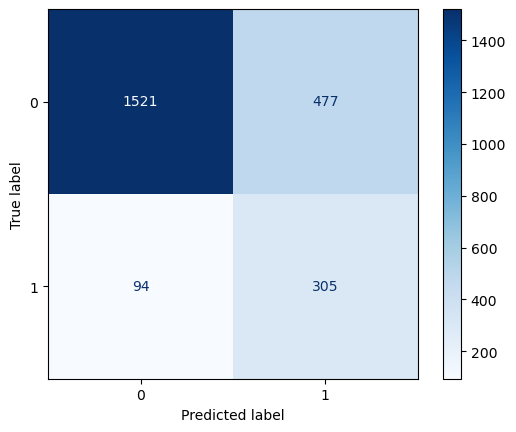

In [37]:
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# --- 4. Train/Test Split ---
# This is a simple split, not using the graph masks
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=None, stratify=y
)

# --- 5. Train Model ---
print("Training Random Forest...")
# We can start with default parameters
rf_model = RandomForestClassifier(
    n_estimators=1000, 
    random_state=None, 
    class_weight="balanced",
    min_samples_leaf=10,
    max_depth=10,
    min_samples_split=2,
    max_features=0.5
)
rf_model.fit(X_train, y_train)

# --- 6. Evaluate Model ---
y_pred = rf_model.predict(X_test)
acc = balanced_accuracy_score(y_test, y_pred)

print("--- Random Forest Classification Report ---")
print(classification_report(y_test, y_pred))
print(f"Balanced Accuracy: {acc:.3f}")
# --- 7. Show Feature Importance ---
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-20:] # Get top 20

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Optionally display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')

print("\n--- Top 20 Most Important Features ---")
for i in reversed(top_indices):
    print(f"{all_feature_names[i]:<30}: {importances[i]:.6f}")

In [38]:
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_validate

# rf_model = RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf_model_kfold = RandomForestClassifier(
    n_estimators=500, 
    random_state=None, 
    class_weight="balanced",
    min_samples_leaf=5
)
print("Running 10-fold cross-validation...")
# cv=10 runs the experiment 10 times on 10 different splits
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=None)
metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}
# scores = cross_val_score(rf_model_kfold, X_final, y, cv=skf, scoring=metrics, n_jobs=-1)
scores = cross_validate(rf_model_kfold, X_final, y, cv=skf, scoring=metrics, n_jobs=-1)
# Aggregate: mean per metric
mean_scores = {m: scores[f'test_{m}'].mean() for m in metrics}
std_scores  = {m: scores[f'test_{m}'].std()  for m in metrics}

print("Mean scores:")
for m in metrics:
    print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")

# print(f"Scores for each fold: {scores}")
# print(f"--- FINAL ACCURACY ---")
# print(f"Mean Accuracy: {scores.mean():.4f}")
# print(f"Std Deviation: {scores.std():.4f}")

Running 10-fold cross-validation...
Mean scores:
 balanced_accuracy: 0.7603 ± 0.0076
                f1: 0.5205 ± 0.0097
         precision: 0.4007 ± 0.0103
            recall: 0.7431 ± 0.0155


In [52]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer

# 1. Define your "search space"
param_dist = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_leaf': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5]
}

# 3. Base RF model
rf_model_tune = RandomForestClassifier(
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

# 4. Stratified 10-fold CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Define multiple metrics
scoring = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall'
}

# 6. Randomized search with multi-metric scoring
rand_search = RandomizedSearchCV(
    estimator=rf_model_tune,
    param_distributions=param_dist,
    n_iter=50,
    cv=skf,
    scoring=scoring,
    refit='balanced_accuracy',   # model will be refit using best balanced_accuracy
    n_jobs=-1,
    verbose=2,
    random_state=42
)

print("Running randomized hyperparameter search...")
rand_search.fit(X_final, y)


Running randomized hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END max_depth=40, max_features=log2, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   2.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000; total time=   4.7s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000; total time=   5.4s
[CV] END max_depth=30, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=500; total time=   3.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=2, n_estimators=1000; total time=   5.9s
[CV] END max_depth=None, max_features=log2, min_samples_leaf=5, min_samples_split=2, n_estimators=1000; total time=   6.2s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, min_samples_split=2, n_estimators=200; total time=   2.3s
[CV] END max_depth=None, max_features=0.5, min_sa

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, None],
                                        'max_features': ['sqrt', 'log2', 0.5],
                                        'min_samples_leaf': [3, 5, 7, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 500, 1000]},
                   random_state=42, refit='balanced_accuracy',
                   scoring={'balanced_accuracy': 'balanced_accuracy',
                            'f1': 'f1', 'precision': 'precision',
                            'recall': 'recall'},
                   verbose=2)

In [53]:
import pandas as pd
import numpy as np

cv_results = rand_search.cv_results_

# Build a nice DataFrame with params + mean/std for each metric
metrics = ['balanced_accuracy', 'f1', 'precision', 'recall']

cols = [
    'param_n_estimators',
    'param_max_depth',
    'param_min_samples_leaf',
    'param_min_samples_split',
    'param_max_features',
]

for m in metrics:
    cols.append(f'mean_test_{m}')
    cols.append(f'std_test_{m}')

results_df = pd.DataFrame(cv_results)[cols]

# Sort primarily by best balanced_accuracy (you can change the metric)
results_df_sorted = results_df.sort_values('mean_test_balanced_accuracy', ascending=False)

print("\n=== All parameter combinations with mean±std per metric ===")
print(results_df_sorted.to_string(index=False))



=== All parameter combinations with mean±std per metric ===
 param_n_estimators param_max_depth  param_min_samples_leaf  param_min_samples_split param_max_features  mean_test_balanced_accuracy  std_test_balanced_accuracy  mean_test_f1  std_test_f1  mean_test_precision  std_test_precision  mean_test_recall  std_test_recall
               1000              10                      10                        2                0.5                     0.729507                    0.011166      0.473575     0.011789             0.350862            0.010158          0.728987         0.024793
                500              10                       3                        2                0.5                     0.723564                    0.008052      0.473288     0.008310             0.358585            0.007504          0.696420         0.020148
                500              10                       3                       10                0.5                     0.723232               

In [54]:
print("\n=== Best parameter set per metric ===")
for m in metrics:
    # rank_test_* is 1 = best, 2 = second, etc.
    ranks = cv_results[f'rank_test_{m}']
    best_idx = np.argmin(ranks)

    print(f"\n--- Best for {m} ---")
    print("Params:", cv_results['params'][best_idx])
    print(f"Mean {m}: {cv_results[f'mean_test_{m}'][best_idx]:.4f} ± {cv_results[f'std_test_{m}'][best_idx]:.4f}")

    # Optional: print per-fold scores (your “matrix” across folds)
    splits = [k for k in cv_results.keys() if k.startswith('split') and k.endswith(f'test_{m}')]
    print("Per-fold scores:")
    for k in splits:
        print(f"  {k}: {cv_results[k][best_idx]}")



=== Best parameter set per metric ===

--- Best for balanced_accuracy ---
Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 10}
Mean balanced_accuracy: 0.7295 ± 0.0112
Per-fold scores:
  split0_test_balanced_accuracy: 0.7102452919272364
  split1_test_balanced_accuracy: 0.734786733657598
  split2_test_balanced_accuracy: 0.7442062198229016
  split3_test_balanced_accuracy: 0.7311661610377782
  split4_test_balanced_accuracy: 0.7271328498047804

--- Best for f1 ---
Params: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 10}
Mean f1: 0.4736 ± 0.0118
Per-fold scores:
  split0_test_f1: 0.4520547945205479
  split1_test_f1: 0.48417721518987344
  split2_test_f1: 0.48444444444444446
  split3_test_f1: 0.472809667673716
  split4_test_f1: 0.4743892828999212

--- Best for precision ---
Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 0.5, 

In [55]:
print("\n--- Best Parameters Found (by balanced_accuracy) ---")
print(rand_search.best_params_)
print(f"\nBest Balanced Accuracy: {rand_search.best_score_:.4f}")



--- Best Parameters Found (by balanced_accuracy) ---
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_depth': 10}

Best Balanced Accuracy: 0.7295


# GNN on Lung cancer

## load Data

In [8]:
v_total_colon = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
v_total_colon = v_total_colon[v_total_colon['label'] == 1]


v_gene: V gene of each TCR clonotype \
j_gene: J gene of each TCR clonotype \
cdr3_nt: Nucleotide sequence over the CDR3 region\
cdr3: Amino acid sequence over the CDR3 region\
templates: Number of UMIs supporting the clonotype\
sample_name: Sample that the clonotype derived from.

In [21]:
serum_df = pd.read_feather("/home/dsi/orrbavly/general/serumdetect_tcr_data.ftr")
serum_meta = pd.read_excel("/home/dsi/orrbavly/general/metadata.xlsx")
serum_meta = serum_meta.set_index('sample_name')

In [10]:
serum_df.head()

,v_gene,j_gene,cdr3_nt,cdr3,templates,sample_name
0,TRBV4-1,TRBJ1-5,TGCGCCAGCAGCCAAGGAGGAGTTAGCAATCAGCCCCAGCATTTT,CASSQGGVSNQPQHF,15,S0108_mRFU2_D01
1,TRBV2,TRBJ1-5,TGTGCCAGCAGTCCGGACAGGGATAGCAATCAGCCCCAGCATTTT,CASSPDRDSNQPQHF,32,S0108_mRFU2_D01
2,TRBV6-1,TRBJ1-5,TGTGCCAGCAGTGATCGGGCAGGGAATAGCAATCAGCCCCAGCATTTT,CASSDRAGNSNQPQHF,32,S0108_mRFU2_D01
3,TRBV6-1,TRBJ1-5,TGTGCCAGCAGTAGCGGGACTCTTAGCAATCAGCCCCAGCATTTT,CASSSGTLSNQPQHF,72,S0108_mRFU2_D01
4,TRBV6-2,TRBJ1-5,TGTGCCAGCAGAACCGACGGGTCTAGCAATCAGCCCCAGCATTTT,CASRTDGSSNQPQHF,28,S0108_mRFU2_D01


In [22]:
serum_meta

,is_cancer,age_years,Gender,race_parsed,stage_parsed,productive_templates,productive_rearrangements,smoking,has_benign_nodule,has_copd,has_heart_disease,median_umi_count,total_umi_M,Histology,VJ_lot
sample_name,,,,,,,,,,,,,,,
S0394_mRFU073_G01,False,66,Female,Caucasian,NaN,5691937,302611,Former smoker,NaN,NaN,NaN,11,5.061063,NaN,A
S0280_mRFU076_H02,False,54,Female,Caucasian,NaN,5026104,183134,Non-smoker,1.0,NaN,NaN,9,4.409110,NaN,A
S0225_mRFU073_F03,False,57,Male,Caucasian,NaN,4752047,204511,Current smoker,NaN,NaN,NaN,11,4.098710,NaN,A
S0643_mRFU075_F01,False,56,Female,Caucasian,NaN,4627253,276229,Current smoker,NaN,NaN,NaN,9,4.126059,NaN,A
S0264_mRFU075_C01,False,56,Female,Caucasian,NaN,4618812,115095,Former smoker,1.0,NaN,NaN,13,4.348374,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0895_mRFU4_H06,True,73,Female,Caucasian,II,953109,28438,Former smoker,NaN,NaN,NaN,15,0.842566,Adenocarcinoma,E
S1032_mRFU19_B03,True,73,Female,Caucasian,I,856189,25762,Non-smoker,NaN,NaN,NaN,24,0.759256,Other,E
S0447_mRFU12_F02,True,68,Male,Caucasian,I,821093,10083,Current smoker,NaN,NaN,NaN,23,0.770273,Large cell carcinoma,E


## RF

Lets try running RF using original HK genes as input for samples.

In [23]:
# --- 1. Get our 1997 HK TCRs (our "columns") ---
hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()
print(f"Loaded {len(hk_tcr_list)} HK TCRs to use as features.")

# --- 2. Get our 1050 Sample Names (our "rows") ---
# This defines our master sample order
all_sample_names = serum_df['sample_name'].dropna().unique()
print(f"Loaded {len(all_sample_names)} unique samples from serum_df.")

# --- 3. Create the 'y' Label Vector ---
# Set 'sample_name' as index for easy, error-free alignment
# serum_meta = serum_meta.set_index('sample_name')

# Reindex the metadata to match our master sample order EXACTLY
# This is critical to prevent misalignment
y_labels_df = serum_meta.reindex(all_sample_names)

# Map True/False to 1/0
y_final = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy()

print(f"Final 'y' (labels) vector shape: {y_final.shape}")

Loaded 1997 HK TCRs to use as features.
Loaded 1050 unique samples from serum_df.
Final 'y' (labels) vector shape: (1050,)


In [20]:
y_labels_df

,sample_name,is_cancer,age_years,Gender,race_parsed,stage_parsed,productive_templates,productive_rearrangements,smoking,has_benign_nodule,has_copd,has_heart_disease,median_umi_count,total_umi_M,Histology,VJ_lot
S0108_mRFU2_D01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0639_mRFU1_G03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0586_mRFU1_G02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0016_mRFU2_B01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0793_mRFU2_G05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0219_mRFU073_C01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0265_mRFU076_H01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0224_mRFU075_E03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S0226_mRFU076_G01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# --- 4. Build X_fingerprint (The Specifics) ---
print("Building X_fingerprint (the [1050, 1997] matrix)...")

# Filter serum_df to *only* our HK TCRs
hk_in_serum_df = serum_df[serum_df['cdr3'].isin(hk_tcr_list)]

# Create the main pivot table
pivot_df = pd.pivot_table(
    hk_in_serum_df,
    index='sample_name',
    columns='cdr3',
    values='templates',   # Use the raw read/template count
    aggfunc='sum',
    fill_value=0
)

# Reindex to get our final, clean [1050, 1997] matrix
X_fingerprint_df = pivot_df.reindex(
    index=all_sample_names,    # Ensures all 1050 samples are rows
    columns=hk_tcr_list,       # Ensures all 1997 TCRs are columns
    fill_value=0
)
print(f"X_fingerprint shape: {X_fingerprint_df.shape}")

# --- 5. Build X_global (The Context) ---
print("Building X_global (the global sample stats)...")

# Group the *entire* serum_df by sample
grouped = serum_df.groupby('sample_name')

# Calculate our global features
stats_df = grouped.agg(
    total_templates=('templates', 'sum'),
    total_unique_tcrs=('cdr3', 'nunique')
)

# Calculate clonality (mean templates)
stats_df['mean_templates_per_tcr'] = stats_df['total_templates'] / stats_df['total_unique_tcrs']

# Define Shannon Entropy function
def shannon_entropy(series):
    proportions = series / series.sum()
    proportions = proportions[proportions > 0]
    return -(proportions * np.log2(proportions)).sum()

# Calculate Shannon Entropy
# This is slow, so we apply it only once
entropy_df = grouped['templates'].apply(shannon_entropy).to_frame(name='shannon_entropy')
stats_df = stats_df.join(entropy_df)

# Reindex to match our master sample order
X_global_df = stats_df.reindex(all_sample_names, fill_value=0)
print(f"X_global shape: {X_global_df.shape}")

# --- 6. Combine into Final 'X' Matrix ---
X_final_enriched = pd.concat([X_fingerprint_df, X_global_df], axis=1)

# Convert to simple NumPy array for sklearn (just in case)
X_final_np = X_final_enriched.fillna(0).to_numpy()

print(f"Final 'X_final_enriched' matrix shape: {X_final_enriched.shape}")
print("-" * 30)

Building X_fingerprint (the [1050, 1997] matrix)...


/tmp/ipykernel_4108864/69091942.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = pd.pivot_table(


X_fingerprint shape: (1050, 1997)
Building X_global (the global sample stats)...


/tmp/ipykernel_4108864/69091942.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = serum_df.groupby('sample_name')


X_global shape: (1050, 4)
Final 'X_final_enriched' matrix shape: (1050, 2001)
------------------------------


In [46]:
X_final_enriched

,CASRQGDTQYF,CASSFGTGELFF,CASSLGLAGGGNEQFF,CASSPGLAGGITDTQYF,CASSEYNQPQHF,CATRDSSYNEQFF,CASSPARGTEAFF,CSVEDGGYEQYF,CASSLGEYNEQFF,CASSSDSNTGELFF,...,CASSLARGNTGELFF,CASSLEGLYEQYF,CASSLVGGDEQYF,CASSRPGTSYEQYF,CASSEEADTQYF,CASSRRAGSTDTQYF,total_templates,total_unique_tcrs,mean_templates_per_tcr,shannon_entropy
sample_name,,,,,,,,,,,,,,,,,,,,,
S0108_mRFU2_D01,0,0,0,0,54,0,0,0,0,0,...,0,0,0,0,0,0,2983472,52985,56.307861,11.664316
S0639_mRFU1_G03,0,14,0,0,0,0,0,0,0,26,...,3,22,0,0,0,0,4206183,142351,29.547969,15.091361
S0586_mRFU1_G02,3,0,18,0,0,0,0,5,0,0,...,21,14,0,0,0,0,3399590,124017,27.412290,15.447889
S0016_mRFU2_B01,0,16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,4830685,151977,31.785632,14.968332
S0793_mRFU2_G05,0,48,1,0,7,0,2,0,0,0,...,0,12,0,118,0,0,4682263,158994,29.449306,16.008272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0219_mRFU073_C01,0,16,0,0,0,0,0,0,0,9,...,0,0,0,0,0,0,793426,37951,20.906590,14.109096
S0265_mRFU076_H01,17,13,0,0,0,0,0,0,0,0,...,25,0,0,0,0,0,3816982,165147,23.112633,15.596970
S0224_mRFU075_E03,0,78,0,29,0,15,0,0,0,0,...,0,3,30,0,0,0,3386086,91518,36.999126,13.238500


where does the biological signal originate from? Global Stats or HK?\
Test only global stats, without HK scores.

In [14]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# --- 1. Define your X and y ---
# X is *only* the 4 global features
X_global_only = X_global_df.fillna(0).to_numpy()
y_labels = y_final

print(f"Running 'Simplicity Test' with X shape: {X_global_only.shape}")
print(f"Using y shape: {y_labels.shape}")

# --- 2. Define Model and CV ---
# We use the *un-tuned* RF, just like our first baseline
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# We want the same metrics for a direct comparison
metrics = ['balanced_accuracy', 'roc_auc']

# --- 3. Run 10-fold Cross-Validation ---
print("\nRunning 10-fold CV on *only* the 4 global features...")
scores = cross_validate(rf_model, X_global_only, y_labels, 
                        cv=skf, scoring=metrics, n_jobs=-1)

# --- 4. Print Final Report ---
print("\n--- 'Simplicity Test' Results (Global Features Only) ---")
print(f"Mean Balanced Accuracy: {scores['test_balanced_accuracy'].mean():.4f} ± {scores['test_balanced_accuracy'].std():.4f}")
print(f"Mean ROC-AUC Score:       {scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}")

print("\n--- Comparison ---")
print(f"Full Model (1997+4 features) BA: 0.6427")
print(f"This Model (4 features)      BA: {scores['test_balanced_accuracy'].mean():.4f}")

Running 'Simplicity Test' with X shape: (1050, 4)
Using y shape: (1050,)

Running 10-fold CV on *only* the 4 global features...

--- 'Simplicity Test' Results (Global Features Only) ---
Mean Balanced Accuracy: 0.6366 ± 0.0427
Mean ROC-AUC Score:       0.6884 ± 0.0485

--- Comparison ---
Full Model (1997+4 features) BA: 0.6427
This Model (4 features)      BA: 0.6366


HK only

In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# --- 1. Define your X and y ---
# X is *only* the 1997 HK fingerprint features
X_hk_only = X_fingerprint_df.fillna(0).to_numpy()
y_labels = y_final

print(f"Running 'HK-Only Test' with X shape: {X_hk_only.shape}")
print(f"Using y shape: {y_labels.shape}")

# --- 2. Define Model and CV ---
rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
metrics = ['balanced_accuracy', 'roc_auc']

# --- 3. Run 10-fold Cross-Validation ---
print("\nRunning 10-fold CV on *only* the 1997 HK features...")
scores = cross_validate(rf_model, X_hk_only, y_labels, 
                        cv=skf, scoring=metrics, n_jobs=-1)

# --- 4. Print Final Report ---
print("\n--- 'HK-Only Test' Results ---")
print(f"Mean Balanced Accuracy: {scores['test_balanced_accuracy'].mean():.4f} ± {scores['test_balanced_accuracy'].std():.4f}")
print(f"Mean ROC-AUC Score:       {scores['test_roc_auc'].mean():.4f} ± {scores['test_roc_auc'].std():.4f}")

print("\n--- Comparison ---")
print(f"Global Stats Model (4 features) BA: 0.6366")
print(f"This Model (1997 features)      BA: {scores['test_balanced_accuracy'].mean():.4f}")

Running 'HK-Only Test' with X shape: (1050, 1997)
Using y shape: (1050,)

Running 10-fold CV on *only* the 1997 HK features...

--- 'HK-Only Test' Results ---
Mean Balanced Accuracy: 0.6131 ± 0.0397
Mean ROC-AUC Score:       0.6670 ± 0.0601

--- Comparison ---
Global Stats Model (4 features) BA: 0.6366
This Model (1997 features)      BA: 0.6131


Grid param search for HK/Global only

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# --- 1. Define your X and y ---
# X is *only* the 1997 HK fingerprint features
X_hk_only = X_fingerprint_df.fillna(0).to_numpy()
y_labels = y_final

print(f"Running 'HK-Only Test' with X shape: {X_hk_only.shape}")
print(f"Using y shape: {y_labels.shape}")

param_dist = {
    'n_estimators': [200, 500, 1000],        # Number of trees
    'max_depth': [10, 20, 30, None],         # Max depth of each tree
    'min_samples_leaf': [1, 3, 5],           # Min samples in a final leaf
    'min_samples_split': [2, 5, 10],         # Min samples to split a node
    'max_features': ['sqrt', 'log2', 0.5]  # Features to use at each split
}

# --- 2. Create the Base Model ---
# This is the estimator we want to tune
base_rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rand_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=50,                   # Try 50 different combinations
    cv=skf,                      # Use our 10-fold stratified split
    scoring='balanced_accuracy', # This is our key metric
    n_jobs=-1,                   # Use all available CPU cores for the CV
    random_state=42
)

print("Running randomized hyperparameter search... (This may take a while)")
rand_search.fit(X_final_np, y_final)

# --- 6. Print the Best Results ---
print("\n--- Best Parameters Found ---")
print(rand_search.best_params_)
print(f"\nBest 10-fold CV Balanced Accuracy: {rand_search.best_score_:.4f}")

Running 'HK-Only Test' with X shape: (1050, 1997)
Using y shape: (1050,)
Running randomized hyperparameter search... (This may take a while)

--- Best Parameters Found ---
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20}

Best 10-fold CV Balanced Accuracy: 0.6515


Feature importance check

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier

# (Assumes X_final_enriched (DataFrame) and y_final (numpy array) are in memory)

# --- 1. Get All Feature Names in Order ---
# This combines the ~1997 TCR names and the ~4 global stat names
all_feature_names = X_final_enriched.columns.to_list()

# --- 2. Convert DataFrame to NumPy Array ---
# (You might have already done this in the previous step)
X_final_np = X_final_enriched.fillna(0).to_numpy()

# --- 3. Train the Model on the *Full* Dataset ---
print("Training model on full dataset to get feature importances...")

rf_model = RandomForestClassifier(
    n_estimators=200,          
    class_weight='balanced',   
    random_state=42,
    min_samples_leaf=5
)

rf_model.fit(X_final_np, y_final)

# --- 4. Get and Print Feature Importances ---
importances = rf_model.feature_importances_

# Combine names and importances into a pandas Series for easy sorting
feat_importance_series = pd.Series(importances, index=all_feature_names)

print("\n--- Top 20 Most Important Features ---")
print(feat_importance_series.nlargest(20))

Training model on full dataset to get feature importances...

--- Top 20 Most Important Features ---
total_unique_tcrs         0.022034
total_templates           0.018204
CASSLASYNEQFF             0.009063
shannon_entropy           0.009000
CASSPGQGETQYF             0.008719
mean_templates_per_tcr    0.007558
CASSRQSTDTQYF             0.006672
CASSLDSSGNTIYF            0.006010
CASSPTGYEQYF              0.005886
CASSLGQGQETQYF            0.005452
CASSLRGTDTQYF             0.004547
CASSRTGSYGYTF             0.004540
CASSFQGNTEAFF             0.004520
CASSLVGGELFF              0.004234
CASSLGGEQYF               0.004213
CASSSTANYGYTF             0.004175
CASSSGSTDTQYF             0.004107
CASSLLAGGRETQYF           0.004088
CASSLGQLNTEAFF            0.004002
CASSLGRGYGYTF             0.003805
dtype: float64


kfold on stacked data

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# --- 7. Define Model and CV ---
rf_model = RandomForestClassifier(
    n_estimators=500,          # Start with 200, we can tune this
    class_weight='balanced',   # CRITICAL for this dataset
    random_state=None,
     min_samples_leaf=5
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

# We want to see the most important, robust metrics
metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}
# --- 8. Run 10-fold Cross-Validation ---
print("\nRunning 10-fold CV on the 'Enriched Fingerprint' model...")
scores = cross_validate(rf_model, X_final_np, y_final, 
                        cv=skf, scoring=metrics, n_jobs=-1)

# --- 9. Print Final Report ---
print("\n--- Final 'HK Fingerprint' Model Results (10-fold CV) ---")
# Aggregate: mean per metric
mean_scores = {m: scores[f'test_{m}'].mean() for m in metrics}
std_scores  = {m: scores[f'test_{m}'].std()  for m in metrics}

print("Mean scores:")
for m in metrics:
    print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")


Running 10-fold CV on the 'Enriched Fingerprint' model...


NameError: name 'X_final_np' is not defined

In [32]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# (Assumes X_final_np [shape 1050, 2001] and y_final [shape 1050,] are in memory)

# --- 1. Calculate scale_pos_weight (The XGBoost 'class_weight') ---
# This is CRITICAL for our 56/44 imbalanced data
n_control_0 = np.sum(y_final == 0) # e.g., 587
n_cancer_1 = np.sum(y_final == 1)  # e.g., 463
scale_pos_weight_val = n_control_0 / n_cancer_1 # e.g., 587 / 463 = 1.267
print(f"Calculated scale_pos_weight: {scale_pos_weight_val:.2f}")

# --- 2. Define the XGBoost Model ---
xgb_model = XGBClassifier(
    n_estimators=500,          # Number of trees
    learning_rate=0.01,         # How fast it learns
    max_depth=3,               # Shallow trees
    scale_pos_weight=scale_pos_weight_val, # <-- THE FIX
    n_jobs=-1,
    random_state=None,
    eval_metric='logloss',
    subsample=0.7, reg_lambda=10,reg_alpha=1.0,
    gamma=1,colsample_bytree=1.0
)

# --- 3. Define CV ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
metrics = {
    'balanced_accuracy': 'balanced_accuracy',
    'f1': 'f1',
    'precision': 'precision',
    'recall': 'recall',
    'roc_auc': 'roc_auc'
}

# --- 4. Run 10-fold Cross-Validation ---
print("\nRunning 10-fold CV on the 'XGBoost' model...")
scores = cross_validate(xgb_model, X_final_np, y_final, 
                        cv=skf, scoring=metrics, n_jobs=-1)

# --- 5. Print Final Report ---
print("\n--- Final 'XGBoost' Model Results (10-fold CV) ---")
# Aggregate: mean per metric
mean_scores = {m: scores[f'test_{m}'].mean() for m in metrics}
std_scores  = {m: scores[f'test_{m}'].std()  for m in metrics}

print("Mean scores:")
for m in metrics:
    print(f"{m:>18}: {mean_scores[m]:.4f} ± {std_scores[m]:.4f}")

Calculated scale_pos_weight: 1.27

Running 10-fold CV on the 'XGBoost' model...

--- Final 'XGBoost' Model Results (10-fold CV) ---
Mean scores:
 balanced_accuracy: 0.6533 ± 0.0281
                f1: 0.5874 ± 0.0390
         precision: 0.6462 ± 0.0365
            recall: 0.5399 ± 0.0483
           roc_auc: 0.6948 ± 0.0408


Param grid search for whole data

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

# (Assumes X_final_np and y_final are in memory)

# --- 1. Define the Hyperparameter Search Space ---
param_dist = {
    'n_estimators': [200, 500, 1000],        # Number of trees
    'max_depth': [10, 20, 30, None],         # Max depth of each tree
    'min_samples_leaf': [1, 3, 5],           # Min samples in a final leaf
    'min_samples_split': [2, 5, 10],         # Min samples to split a node
    'max_features': ['sqrt', 'log2', 0.5]  # Features to use at each split
}

# --- 2. Create the Base Model ---
# This is the estimator we want to tune
base_rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
)

# --- 3. Create the 10-Fold CV Splitter ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# --- 4. Set up the Randomized Search ---
rand_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=param_dist,
    n_iter=50,                   # Try 50 different combinations
    cv=skf,                      # Use our 10-fold stratified split
    scoring='balanced_accuracy', # This is our key metric
    n_jobs=-1,                   # Use all available CPU cores for the CV
    random_state=42
)

# --- 5. Run the Search ---
print("Running randomized hyperparameter search... (This may take a while)")
rand_search.fit(X_final_np, y_final)

# --- 6. Print the Best Results ---
print("\n--- Best Parameters Found ---")
print(rand_search.best_params_)
print(f"\nBest 10-fold CV Balanced Accuracy: {rand_search.best_score_:.4f}")

Running randomized hyperparameter search... (This may take a while)



--- Best Parameters Found ---
{'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 20}

Best 10-fold CV Balanced Accuracy: 0.6515


In [28]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, balanced_accuracy_score, roc_auc_score

# (Assumes X_final_np and y_final are in memory)

# --- 1. Calculate scale_pos_weight (Unchanged) ---
n_control_0 = np.sum(y_final == 0)
n_cancer_1 = np.sum(y_final == 1)
scale_pos_weight_val = n_control_0 / n_cancer_1
print(f"Using scale_pos_weight (Control/Cancer): {scale_pos_weight_val:.4f}")

# --- 2. Define the Hyperparameter Search Space (Unchanged) ---
# This is fine, we can keep it as-is
param_dist = {
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
    'gamma': [0, 0.1, 0.5, 1],
    'reg_lambda': [0.1, 1.0, 10],
    'reg_alpha': [0, 0.1, 1.0]
}

# --- 3. Define the *Multiple* Scorers (Unchanged) ---
scoring_metrics = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'roc_auc': make_scorer(roc_auc_score),
    'precision_macro': make_scorer(precision_score, average='macro'),
    'recall_macro': make_scorer(recall_score, average='macro')
}

# --- 4. Create the Base XGBoost Model (MODIFIED) ---
xgb_model = XGBClassifier(
    scale_pos_weight=scale_pos_weight_val,
    random_state=42,
    eval_metric='logloss',
    n_jobs=1,                  # <-- Tell the *inner* XGB to be serial
    tree_method='hist',     # <-- Explicitly tell it to use the GPU
    device='cuda'
)

# --- 5. Create the 10-Fold CV Splitter (Unchanged) ---
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

# --- 6. Set up the Randomized Search (MODIFIED) ---
rand_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=skf,
    scoring=scoring_metrics,
    refit='balanced_accuracy',
    n_jobs=1,                    # <-- **THIS IS THE MAIN FIX**
                                 # This forces the CV to run one fold at a time
    verbose=2,
    random_state=None
)

# --- 7. Run the Search ---
print("\nRunning (serial) randomized hyperparameter search for XGBoost... (This will be slower but safer)")
rand_search.fit(X_final_np, y_final)

# --- 8. Print the Best Results (Unchanged) ---
# ... (The rest of your print/reporting code is perfect) ...

# --- 8. Print the Best Results ---
print("\n--- Best XGBoost Parameters Found ---")
print(rand_search.best_params_)

print(f"\n--- Best 10-fold CV Scores (for the single best model) ---")

# Get the index of the best model (the one with the highest 'refit' score)
best_index = rand_search.best_index_

# Use that index to pull all the corresponding scores from the results dictionary
results = rand_search.cv_results_

ba_mean = results['mean_test_balanced_accuracy'][best_index]
ba_std = results['std_test_balanced_accuracy'][best_index]

roc_mean = results['mean_test_roc_auc'][best_index]
roc_std = results['std_test_roc_auc'][best_index]

prec_mean = results['mean_test_precision_macro'][best_index]
prec_std = results['std_test_precision_macro'][best_index]

rec_mean = results['mean_test_recall_macro'][best_index]
rec_std = results['std_test_recall_macro'][best_index]

print(f"Balanced Accuracy: {ba_mean:.4f} ± {ba_std:.4f} (This was optimized)")
print(f"ROC-AUC:           {roc_mean:.4f} ± {roc_std:.4f}")
print(f"Precision (Macro): {prec_mean:.4f} ± {prec_std:.4f}")
print(f"Recall (Macro):    {rec_mean:.4f} ± {rec_std:.4f}")

print("\n--- Comparison ---")
print(f"Champion RF Score (BA): 0.6515")
print(f"This XGBoost Score (BA):{ba_mean:.4f}")

Using scale_pos_weight (Control/Cancer): 1.2678

Running (serial) randomized hyperparameter search for XGBoost... (This will be slower but safer)
Fitting 10 folds for each of 50 candidates, totalling 500 fits
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=1.0; total time=   0.9s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=1.0; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=1, learning_rate=0.05, max_depth=10, n_estimators=200, reg_alpha=0, reg_lambda=10, subsample=1.0; total time=   0.8s
[CV] END colsample_by

## GNN

In [ ]:
import time
import pandas as pd
import numpy as np
import torch
import dgl

from rapidfuzz import process, distance
from sklearn.neighbors import NearestNeighbors

K_NEIGHBORS = 10
OUTPUT_GRAPH_FILE = "/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/g_master_edit_dist_one_1997_3.bin"  # Saved DGL graph

tcr_list = (
    v_total_colon['cdr3_seq']
    .dropna()
    .astype(str)
    .unique()
    .tolist()
)
n_nodes = len(tcr_list)
print(f"Loaded {n_nodes} unique TCRs.")

# --- 2. Calculate Pairwise Edit Distance Matrix ---
print(f"Calculating ({n_nodes}, {n_nodes}) edit distance matrix (Levenshtein)...")
start_time = time.time()

# process.cdist returns a 2D array of distances
dist_matrix = process.cdist(
    tcr_list,
    tcr_list,
    scorer=distance.Levenshtein.distance,
    workers=-1  # use all cores
)

# ensure it's a NumPy array, and optionally cast to float32/int32
dist_matrix = np.asarray(dist_matrix, dtype=np.float32)

end_time = time.time()
print(f"Distance matrix shape: {dist_matrix.shape}")
print(f"Matrix calculation finished in {end_time - start_time:.2f} seconds.")

# --- 3. Find k-NN from the Distance Matrix ---
print(f"Finding k={K_NEIGHBORS} nearest neighbors from distance matrix...")

# precomputed metric: we already have distances
nbrs = NearestNeighbors(
    n_neighbors=K_NEIGHBORS + 1,   # +1 because first neighbor is itself (distance 0)
    metric='precomputed',
    n_jobs=-1
)
nbrs.fit(dist_matrix)

distances_knn, indices_knn = nbrs.kneighbors(dist_matrix)

# skip the self index at column 0
knn_indices = indices_knn[:, 1:]  # shape: (n_nodes, K)
print("k-NN search complete.")

# --- 4. Build the DGL Graph from kNN indices ---
print("Building DGL graph from k-NN adjacency...")

# sources: each node repeated K times
u = torch.arange(n_nodes, dtype=torch.int64).repeat_interleave(K_NEIGHBORS)

# destinations: flattened neighbor indices
v = torch.tensor(knn_indices.reshape(-1), dtype=torch.int64)

g_master = dgl.graph((u, v), num_nodes=n_nodes)

# make it undirected (optional but common for GNNs)
g_master = dgl.to_simple(g_master)          # remove duplicate edges
g_master = dgl.add_self_loop(g_master)      # add self-loops if you want them

print(f"Master graph built: {g_master}")
print(f"Number of nodes: {g_master.num_nodes()}")
print(f"Number of edges: {g_master.num_edges()}")

# --- 5. Save the Final Graph to Disk ---
print(f"Saving master graph to {OUTPUT_GRAPH_FILE}...")
dgl.save_graphs(OUTPUT_GRAPH_FILE, [g_master])
print("Done.")


Loaded 1997 unique TCRs.
Calculating (1997, 1997) edit distance matrix (Levenshtein)...
Distance matrix shape: (1997, 1997)
Matrix calculation finished in 0.04 seconds.
Finding k=10 nearest neighbors from distance matrix...
k-NN search complete.
Building DGL graph from k-NN adjacency...
Master graph built: Graph(num_nodes=1997, num_edges=21967,
      ndata_schemes={}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)})
Number of nodes: 1997
Number of edges: 21967
Saving master graph to /dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/g_master_edit_dist_one_1997_3.bin...
Done.


### Load Data

In [62]:
static_cvc_feats = pd.read_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_embedded_v2.pkl")
static_cvc_feats.shape

(3994, 769)

In [40]:
graphs, aux_data = dgl.load_graphs("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/g_master_edit_dist_one_1997_3.bin")
G_master = graphs[0]
print(f"Master graph Loaded: {G_master}")


Master graph Loaded: Graph(num_nodes=1997, num_edges=21967,
      ndata_schemes={}
      edata_schemes={'count': Scheme(shape=(), dtype=torch.int64)})


In [44]:
hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()
print(f"Loaded {len(hk_tcr_list)} HK TCRs to use as features.")

all_sample_names = serum_df['sample_name'].dropna().unique()
print(f"Loaded {len(all_sample_names)} unique samples from serum_df.")

serum_meta = serum_meta.set_index('sample_name')
y_labels_df = serum_meta.reindex(all_sample_names)
# Map True/False to 1/0
y_final = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy()

print(f"Final 'y' (labels) vector shape: {y_final.shape}")

print("Building X_global (the global sample stats)...")
grouped = serum_df.groupby('sample_name')
stats_df = grouped.agg(
    total_templates=('templates', 'sum'),
    total_unique_tcrs=('cdr3', 'nunique')
)

stats_df['mean_templates_per_tcr'] = stats_df['total_templates'] / stats_df['total_unique_tcrs']
def shannon_entropy(series):
    proportions = series / series.sum()
    proportions = proportions[proportions > 0]
    return -(proportions * np.log2(proportions)).sum()

entropy_df = grouped['templates'].apply(shannon_entropy).to_frame(name='shannon_entropy')
stats_df = stats_df.join(entropy_df)

X_global_df = stats_df.reindex(all_sample_names, fill_value=0)
print(f"X_global shape: {X_global_df.shape}")


Loaded 1997 HK TCRs to use as features.
Loaded 1050 unique samples from serum_df.


KeyError: "None of ['sample_name'] are in the columns"

In [ ]:
from sklearn.preprocessing import LabelEncoder

# --- 2. Build CVC Lookup Tensor ---
# User provided: static_cvc_feats (DataFrame with 'Sequences' col)
cvc_lookup_df = static_cvc_feats.set_index('Sequences')

# Reindex to match our master 0-1996 order
cvc_lookup_df = cvc_lookup_df.reindex(hk_tcr_list)

# Convert to a PyTorch tensor and save
static_cvc_features = torch.tensor(cvc_lookup_df.fillna(0).values, dtype=torch.float32)
print(f"Created static CVC feature tensor: {static_cvc_features.shape}")

# --- 3. Build V/J Gene Lookup Tensor ---
print("Finding canonical V/J genes from serum_df...")
# Find the *first* V/J gene we see for each HK TCR in the new dataset
df_vj = serum_df[serum_df['cdr3'].isin(hk_tcr_list)]

# We group by cdr3 and find the 'mode' (most frequent value) for V/J
# .mode().iloc[0] gets the most frequent value (and handles ties)
# We add a check for empty modes to avoid errors
def get_mode(series):
    mode = series.mode()
    return mode.iloc[0] if not mode.empty else np.nan

df_canonical_vj = df_vj.groupby('cdr3')[['v_gene', 'j_gene']].agg(get_mode)
# Reindex to match our master 0-1996 order 
df_canonical_vj = df_canonical_vj.reindex(hk_tcr_list)

# We must LabelEncode these V/J strings into integers
v_encoder = LabelEncoder()
j_encoder = LabelEncoder()

# Use .astype(str) to handle any NaNs (which become 'nan')
df_canonical_vj['v_gene_id'] = v_encoder.fit_transform(df_canonical_vj['v_gene'].astype(str))
df_canonical_vj['j_gene_id'] = j_encoder.fit_transform(df_canonical_vj['j_gene'].astype(str))

# ** These are CRITICAL for building the model later **
num_v_classes = len(v_encoder.classes_)
num_j_classes = len(j_encoder.classes_)
print(f"Found {num_v_classes} V-Gene classes and {num_j_classes} J-Gene classes.")

# Convert to a PyTorch tensor and save
static_vj_features = torch.tensor(df_canonical_vj[['v_gene_id', 'j_gene_id']].values, dtype=torch.long)
print(f"Created static V/J feature tensor: {static_vj_features.shape}")

Created static CVC feature tensor: torch.Size([1997, 768])
Finding canonical V/J genes from serum_df...
Found 38 V-Gene classes and 14 J-Gene classes.
Created static V/J feature tensor: torch.Size([1997, 2])


In [42]:
# --- 2. Create the CRITICAL 'cdr3_to_node_id' Map ---
# We need to map the 'cdr3_seq' string to its node ID in G_master
# We'll create a dictionary for O(1) lookups.
hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()
cdr3_to_node_id = {cdr3: i for i, cdr3 in enumerate(hk_tcr_list)}
print(f"Created cdr3_to_node_id map for {len(cdr3_to_node_id)} TCRs.")

# --- 3. Pre-process serum_df for efficient lookup ---
print("Pre-processing serum_df by grouping...")
serum_grouped = serum_df[serum_df['cdr3'].isin(cdr3_to_node_id)].groupby('sample_name')

# --- 4. Build the 1050 Data Packets ---
print(f"Building {len(all_sample_names)} data packets...")
dataset_list = []
for i, sample_name in enumerate(all_sample_names):
    
    label_i = torch.tensor(y_final[i], dtype=torch.long)
    x_global_i = torch.tensor(X_global_df.loc[sample_name].values, dtype=torch.float32)

    try:
        sample_tcrs_df = serum_grouped.get_group(sample_name)
    except KeyError:
        # Create an "empty" graph with 1 node
        g_i = dgl.graph(([], []), num_nodes=1)
        # Give it all the correct, but empty, feature tensors
        g_i.ndata['feat_dyn'] = torch.zeros((1, 1), dtype=torch.float32) 
        g_i.ndata['feat_static_cvc'] = torch.zeros((1, 768), dtype=torch.float32) # <-- Corrected dim
        g_i.ndata['feat_static_vj'] = torch.zeros((1, 2), dtype=torch.long)
        dataset_list.append((g_i, x_global_i, label_i))
        continue

    node_indices_i = [] # G_master IDs (e.g., 5, 42, 1900)
    node_features_dyn_i = [] # 'templates'
    
    for _, row in sample_tcrs_df.iterrows():
        node_id = cdr3_to_node_id.get(row['cdr3'])
        if node_id is not None:
            node_indices_i.append(node_id)
            node_features_dyn_i.append(row['templates'])

    if not node_indices_i:
        # Safeguard: treat as empty
        g_i = dgl.graph(([], []), num_nodes=1)
        g_i.ndata['feat_dyn'] = torch.zeros((1, 1), dtype=torch.float32) 
        g_i.ndata['feat_static_cvc'] = torch.zeros((1, 768), dtype=torch.float32) # <-- Corrected dim
        g_i.ndata['feat_static_vj'] = torch.zeros((1, 2), dtype=torch.long)
        dataset_list.append((g_i, x_global_i, label_i))
        continue
        
    # Build the Subgraph 'g_i'
    g_i = dgl.node_subgraph(G_master, node_indices_i)

    # --- Assign ALL 3 Node Feature Sets ---
    
    # 1. Dynamic Feature (from Data B) - Normalized
    templates_tensor = torch.tensor(node_features_dyn_i, dtype=torch.float32)
    g_i.ndata['feat_dyn'] = torch.log1p(templates_tensor).unsqueeze(1) # Shape [N_i, 1]
    
    # 2. Static CVC Features (from Lookup)
    g_i.ndata['feat_static_cvc'] = static_cvc_features[node_indices_i] # Shape [N_i, 768]
    
    # 3. Static V/J Features (from Lookup)
    g_i.ndata['feat_static_vj'] = static_vj_features[node_indices_i] # Shape [N_i, 2]

    dataset_list.append((g_i, x_global_i, label_i))

print(f"Finished building {len(dataset_list)} data packets.")
print("\n--- Example Data Packet (Sample 0) ---")
g0, x_global0, y0 = dataset_list[0]
print(f"Graph: {g0}")
print(f"Dynamic Node Feats Shape: {g0.ndata['feat_dyn'].shape}")
print(f"Static CVC Feats Shape:   {g0.ndata['feat_static_cvc'].shape}")
print(f"Static VJ Feats Shape:    {g0.ndata['feat_static_vj'].shape}")
print(f"Global Stats Shape:       {x_global0.shape}")
print(f"Label: {y0}")

Created cdr3_to_node_id map for 1997 TCRs.
Pre-processing serum_df by grouping...


/tmp/ipykernel_4108864/816482630.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  serum_grouped = serum_df[serum_df['cdr3'].isin(cdr3_to_node_id)].groupby('sample_name')


Building 1050 data packets...


NameError: name 'static_cvc_features' is not defined

### Define GNN Model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl.nn.pytorch import GINConv
from dgl.nn.pytorch.glob import GlobalAttentionPooling

class UltimateHybridGNN(nn.Module):
    def __init__(self, 
                 # CVC/Dynamic Dims
                 cvc_dim=768,
                 dyn_dim=1,
                 
                 # V/J Gene Dims (from Stage 2A)
                 num_v_classes=38,
                 num_j_classes=14,
                 vj_embed_dim=16, # Our choice: 16-dim vector for each gene
                 
                 # GNN Layer Dims
                 gnn_hidden_dim=64, # Main GNN processing dim
                 gnn_output_dim=32, # Final "graph fingerprint" size
                 
                 # Global Stats MLP Dims
                 global_input_dim=4, # total_templates, shannon, etc.
                 global_output_dim=16, # Final "global stats" vector size
                 
                 # Classifier Dims
                 dropout_rate=0.5,
                 n_classes=2):
        
        super(UltimateHybridGNN, self).__init__()
        
        # --- 1. Node Feature Encoders (The "Front Door") ---
        # Encoders for our 3 types of node features
        self.cvc_mlp = nn.Linear(cvc_dim, gnn_hidden_dim // 2) # e.g., 768 -> 32
        self.dyn_mlp = nn.Linear(dyn_dim, 16)                   # e.g., 1 -> 16
        # Embeddings for our 2 categorical gene features
        self.v_embed = nn.Embedding(num_v_classes, vj_embed_dim) # e.g., 50 -> 16
        self.j_embed = nn.Embedding(num_j_classes, vj_embed_dim) # e.g., 15 -> 16
        
        # Calculate the final, combined GNN input dimension
        # 32 (cvc) + 16 (dyn) + 16 (v) + 16 (j) = 80
        total_gnn_input_dim = (gnn_hidden_dim // 2) + 16 + (vj_embed_dim * 2)

        # --- 2. GNN (Arm 1: The Graph Processor) ---
        # GIN layer. It needs an MLP to process the features.
        gin_mlp = nn.Sequential(
            nn.Linear(total_gnn_input_dim, gnn_hidden_dim),
            nn.ReLU(),
            nn.Linear(gnn_hidden_dim, gnn_hidden_dim)
        )
        self.gin_conv = GINConv(apply_func=gin_mlp, aggregator_type='sum')
        
        # Global Attention Pooling (to summarize the graph)
        pooling_gate_nn = nn.Linear(gnn_hidden_dim, 1)
        self.pooling_layer = GlobalAttentionPooling(gate_nn=pooling_gate_nn)
        
        # Final output layer for the GNN "arm"
        self.gnn_output_mlp = nn.Linear(gnn_hidden_dim, gnn_output_dim)

        # --- 3. Global Stats (Arm 2: The Side Processor) ---
        self.global_encoder = nn.Sequential(
            nn.Linear(global_input_dim, global_output_dim),
            nn.ReLU(),
            nn.Linear(global_output_dim, global_output_dim)
        )
        
        # --- 4. Final Classifier (The Head) ---
        total_combined_dim = gnn_output_dim + global_output_dim # 32 + 16 = 48
        
        self.classifier_mlp = nn.Sequential(
            nn.Linear(total_combined_dim, total_combined_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(total_combined_dim // 2, n_classes)
        )

    def forward(self, g, x_global):
        # 1. Get all 3 node feature types from the graph batch
        f_cvc = g.ndata['feat_static_cvc']
        f_vj_ids = g.ndata['feat_static_vj']
        f_dyn = g.ndata['feat_dyn']
        
        # 2. Process all 3 node feature types
        h_cvc = F.relu(self.cvc_mlp(f_cvc))            # [N_nodes_in_batch, 32]
        h_dyn = F.relu(self.dyn_mlp(f_dyn))            # [N_nodes_in_batch, 16]
        h_v = self.v_embed(f_vj_ids[:, 0])             # [N_nodes_in_batch, 16]
        h_j = self.j_embed(f_vj_ids[:, 1])             # [N_nodes_in_batch, 16]
        
        # 3. Combine into ONE feature vector 'h' for the GNN
        h = torch.cat([h_cvc, h_dyn, h_v, h_j], dim=1) # [N_nodes_in_batch, 80]
        
        # 4. Run Arm 1 (The GNN)
        h_graph = F.relu(self.gin_conv(g, h))
        h_pooled = self.pooling_layer(g, h_graph)
        h_graph_final = F.relu(self.gnn_output_mlp(h_pooled)) # [BatchSize, 32]
        
        # 5. Run Arm 2 (The Global Stats MLP)
        h_global_final = F.relu(self.global_encoder(x_global)) # [BatchSize, 16]
        
        # 6. Combine and Classify
        h_combined = torch.cat([h_graph_final, h_global_final], dim=1) # [BatchSize, 48]
        
        return self.classifier_mlp(h_combined)

In [ ]:
from torch.utils.data import Subset
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
import numpy as np

# --- Stage 4: Define the Collate Function ---
# This is a "helper" that tells the dataloader how to 
# combine our (g, x_global, y) packets into a batch

def collate_fn(samples):
    # samples is a list of (g, x_global, y) tuples
    graphs, global_stats, labels = map(list, zip(*samples))
    
    # 1. Batch the graphs
    batched_graph = dgl.batch(graphs)
    
    # 2. Stack the global stats and labels
    batched_global_stats = torch.stack(global_stats)
    batched_labels = torch.stack(labels)
    
    return batched_graph, batched_global_stats, batched_labels


### Run GNN

In [ ]:
# --- Config for the CV Loop ---
k_folds = 10
n_epochs = 100 # We may need to tune this
learning_rate = 0.001
batch_size = 32

print(f"\n--- Starting 10-Fold CV Training on {device} ---")

# We need the raw 'y' labels for the StratifiedKFold
raw_labels = [label.item() for _, _, label in dataset_list]

skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=0)

# Lists to store the final scores from each fold
fold_ba_scores = []
fold_roc_auc_scores = []

# --- Stage 5: The 10-Fold Cross-Validation Loop ---
for fold, (train_idx, test_idx) in enumerate(skf.split(np.zeros(len(dataset_list)), raw_labels)):
    
    print(f"\n--- Fold {fold+1}/{k_folds} ---")
    
    train_subset = Subset(dataset_list, train_idx)
    test_subset = Subset(dataset_list, test_idx)

    train_loader = GraphDataLoader(train_subset, batch_size=batch_size, 
                                   shuffle=True, collate_fn=collate_fn, drop_last=True)
    test_loader = GraphDataLoader(test_subset, batch_size=batch_size, 
                                  shuffle=False, collate_fn=collate_fn)

    # 3. Instantiate our "Ultimate" Model
    model = UltimateHybridGNN(
        cvc_dim=768,
        dyn_dim=1,
        num_v_classes=num_v_classes,  # From Stage 2A
        num_j_classes=num_j_classes,  # From Stage 2A
        vj_embed_dim=16,
        gnn_hidden_dim=64,
        gnn_output_dim=32,
        global_input_dim=4,
        global_output_dim=16,
        n_classes=2
    ).to(device)
    
    # Calculate class weights for this fold
    train_labels = [raw_labels[i] for i in train_idx]
    n_class_0 = train_labels.count(0)
    n_class_1 = train_labels.count(1)
    weight_0 = (n_class_0 + n_class_1) / (2.0 * n_class_0)
    weight_1 = (n_class_0 + n_class_1) / (2.0 * n_class_1)
    class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32).to(device)
    
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

    # --- Inner Training Loop ---
    for epoch in range(n_epochs):
        model.train()
        for (g_batch, x_global_batch, y_batch) in train_loader:
            g_batch, x_global_batch, y_batch = \
                g_batch.to(device), x_global_batch.to(device), y_batch.to(device)
            
            logits = model(g_batch, x_global_batch)
            loss = loss_fn(logits, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    # --- Inner Evaluation Loop ---
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for (g_batch, x_global_batch, y_batch) in test_loader:
            g_batch, x_global_batch, y_batch = \
                g_batch.to(device), x_global_batch.to(device), y_batch.to(device)
                
            logits = model(g_batch, x_global_batch)
            probs = F.softmax(logits, dim=1)[:, 1]
            preds = torch.argmax(logits, dim=1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(y_batch.cpu().numpy())
            all_probs.append(probs.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)
    
    ba_score = balanced_accuracy_score(all_labels, all_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    fold_ba_scores.append(ba_score)
    fold_roc_auc_scores.append(roc_auc)
    
    print(f"Fold {fold+1} Results: BA = {ba_score:.4f}, ROC-AUC = {roc_auc:.4f}")

# --- Final Report ---
print("\n--- Final 'Ultimate GNT' Model Results (10-fold CV) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC Score:       {np.mean(fold_roc_auc_scores):.4f} ± {np.std(fold_roc_auc_scores):.4f}")

print("\n--- Comparison ---")
print(f"Champion RF Score (BA): 0.6515")
print(f"This GNN Score (BA):    {np.mean(fold_ba_scores):.4f}")


--- Starting 10-Fold CV Training on cuda ---

--- Fold 1/10 ---
Fold 1 Results: BA = 0.5000, ROC-AUC = 0.5000

--- Fold 2/10 ---
Fold 2 Results: BA = 0.5024, ROC-AUC = 0.5026

--- Fold 3/10 ---
Fold 3 Results: BA = 0.5109, ROC-AUC = 0.5109

--- Fold 4/10 ---
Fold 4 Results: BA = 0.4939, ROC-AUC = 0.4943

--- Fold 5/10 ---
Fold 5 Results: BA = 0.5000, ROC-AUC = 0.5000

--- Fold 6/10 ---
Fold 6 Results: BA = 0.5217, ROC-AUC = 0.5188

--- Fold 7/10 ---
Fold 7 Results: BA = 0.5000, ROC-AUC = 0.5000

--- Fold 8/10 ---
Fold 8 Results: BA = 0.5106, ROC-AUC = 0.5083

--- Fold 9/10 ---
Fold 9 Results: BA = 0.4848, ROC-AUC = 0.4850

--- Fold 10/10 ---
Fold 10 Results: BA = 0.5000, ROC-AUC = 0.5000

--- Final 'Ultimate GNT' Model Results (10-fold CV) ---
Mean Balanced Accuracy: 0.5024 ± 0.0096
Mean ROC-AUC Score:       0.5020 ± 0.0088

--- Comparison ---
Champion RF Score (BA): 0.6515
This GNN Score (BA):    0.5024


In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import numpy as np
from torch.utils.data import Subset
from dgl.dataloading import GraphDataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report

# (Assumes: UltimateHybridGNN class is defined)
# (Assumes: collate_fn is defined)
# (Assumes: dataset_list, raw_labels, num_v_classes, num_j_classes are in memory)

# --- 1. Config for the Single Run ---
n_epochs = 100
learning_rate = 0.001
batch_size = 32
test_split_size = 0.15  # 15% for final test
val_split_size = 0.15   # 15% for validation (of the original 100%)

print(f"--- Starting Single Train/Val/Test Run on {device} ---")

# --- 2. Create Train/Val/Test Splits (Stratified) ---
n_samples = len(dataset_list)
indices = list(range(n_samples))

# First, split into (Train + Val) and Test
train_val_indices, test_indices = train_test_split(
    indices,
    test_size=test_split_size,
    stratify=raw_labels,
    random_state=None
)

# Get the labels for the remaining (Train + Val) set
train_val_labels = [raw_labels[i] for i in train_val_indices]

# Calculate the new validation split size (e.g., 0.15 / 0.85 = 0.176)
val_size_of_remainder = val_split_size / (1.0 - test_split_size)

# Second, split (Train + Val) into Train and Val
train_indices, val_indices = train_test_split(
    train_val_indices,
    test_size=val_size_of_remainder,
    stratify=train_val_labels,
    random_state=42
)

# Create Subsets
train_subset = Subset(dataset_list, train_indices)
val_subset = Subset(dataset_list, val_indices)
test_subset = Subset(dataset_list, test_indices)

print(f"Total Samples: {n_samples}")
print(f"Train Samples: {len(train_subset)}")
print(f"Val Samples:   {len(val_subset)}")
print(f"Test Samples:  {len(test_subset)}")

# --- 3. Create DataLoaders ---
train_loader = GraphDataLoader(train_subset, batch_size=batch_size, 
                               shuffle=True, collate_fn=collate_fn, drop_last=True)
val_loader = GraphDataLoader(val_subset, batch_size=batch_size, 
                              shuffle=False, collate_fn=collate_fn)
test_loader = GraphDataLoader(test_subset, batch_size=batch_size, 
                              shuffle=False, collate_fn=collate_fn)

# --- 4. Instantiate Model and Optimizer ---
model = UltimateHybridGNN(
    cvc_dim=768,
    dyn_dim=1,
    num_v_classes=num_v_classes,
    num_j_classes=num_j_classes,
    vj_embed_dim=16,
    gnn_hidden_dim=64,
    gnn_output_dim=32,
    global_input_dim=4,
    global_output_dim=16,
    n_classes=2
).to(device)

# Calculate class weights *only* from the training set
train_labels = [raw_labels[i] for i in train_indices]
n_class_0 = train_labels.count(0)
n_class_1 = train_labels.count(1)
weight_0 = (n_class_0 + n_class_1) / (2.0 * n_class_0)
weight_1 = (n_class_0 + n_class_1) / (2.0 * n_class_1)
class_weights = torch.tensor([weight_0, weight_1], dtype=torch.float32).to(device)

loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# --- 5. The Training Loop (with Train/Val Loss) ---
print("\n--- Starting Training ---")
for epoch in range(n_epochs):
    # --- Training Step ---
    model.train()
    epoch_train_loss = 0
    for (g_batch, x_global_batch, y_batch) in train_loader:
        g_batch, x_global_batch, y_batch = \
            g_batch.to(device), x_global_batch.to(device), y_batch.to(device)
        
        logits = model(g_batch, x_global_batch)
        loss = loss_fn(logits, y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)

    # --- Validation Step ---
    model.eval()
    epoch_val_loss = 0
    all_preds_val = []
    all_labels_val = []
    with torch.no_grad():
        for (g_batch, x_global_batch, y_batch) in val_loader:
            g_batch, x_global_batch, y_batch = \
                g_batch.to(device), x_global_batch.to(device), y_batch.to(device)
                
            logits = model(g_batch, x_global_batch)
            loss = loss_fn(logits, y_batch)
            epoch_val_loss += loss.item()
            
            preds = torch.argmax(logits, dim=1)
            all_preds_val.append(preds.cpu().numpy())
            all_labels_val.append(y_batch.cpu().numpy())

    avg_val_loss = epoch_val_loss / len(val_loader)
    all_preds_val = np.concatenate(all_preds_val)
    all_labels_val = np.concatenate(all_labels_val)
    val_ba = balanced_accuracy_score(all_labels_val, all_preds_val)

    # Print the epoch-by-epoch results
    if epoch % 5 == 0 or epoch == n_epochs - 1:
        print(f"Epoch {epoch:03d} | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val BA: {val_ba:.4f}")

print("Training finished.")

# --- 6. Final Test (on the held-out Test Set) ---
print("\n--- Running Final Test ---")
model.eval()
all_preds_test = []
all_labels_test = []
all_probs_test = []
with torch.no_grad():
    for (g_batch, x_global_batch, y_batch) in test_loader:
        g_batch, x_global_batch, y_batch = \
            g_batch.to(device), x_global_batch.to(device), y_batch.to(device)
            
        logits = model(g_batch, x_global_batch)
        probs = F.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        all_preds_test.append(preds.cpu().numpy())
        all_labels_test.append(y_batch.cpu().numpy())
        all_probs_test.append(probs.cpu().numpy())

all_preds_test = np.concatenate(all_preds_test)
all_labels_test = np.concatenate(all_labels_test)
all_probs_test = np.concatenate(all_probs_test)

# Calculate final metrics
test_ba = balanced_accuracy_score(all_labels_test, all_preds_test)
test_roc_auc = roc_auc_score(all_labels_test, all_probs_test)

print("\n--- Final 'Ultimate GNN' Test Results ---")
print(f"Test Balanced Accuracy: {test_ba:.4f}")
print(f"Test ROC-AUC Score:       {test_roc_auc:.4f}")

print("\n--- Comparison ---")
print(f"Champion RF Score (BA): 0.6515")
print(f"This GNN Score (BA):    {test_ba:.4f}")

print("\n--- Full Classification Report (Test Set) ---")
print(classification_report(all_labels_test, all_preds_test, target_names=['Control (0)', 'Cancer (1)']))

--- Starting Single Train/Val/Test Run on cuda ---
Total Samples: 1050
Train Samples: 734
Val Samples:   158
Test Samples:  158

--- Starting Training ---
Epoch 000 | Train Loss: 9192.0367 | Val Loss: 368.3639 | Val BA: 0.4680
Epoch 005 | Train Loss: 0.8551 | Val Loss: 1.1674 | Val BA: 0.5552
Epoch 010 | Train Loss: 0.8752 | Val Loss: 1.3147 | Val BA: 0.4901
Epoch 015 | Train Loss: 0.7449 | Val Loss: 0.7385 | Val BA: 0.5000
Epoch 020 | Train Loss: 0.6914 | Val Loss: 0.7032 | Val BA: 0.5000
Epoch 025 | Train Loss: 0.6849 | Val Loss: 0.7044 | Val BA: 0.5000
Epoch 030 | Train Loss: 0.6858 | Val Loss: 0.7052 | Val BA: 0.5000
Epoch 035 | Train Loss: 0.6847 | Val Loss: 0.7053 | Val BA: 0.5446
Epoch 040 | Train Loss: 0.6838 | Val Loss: 0.7146 | Val BA: 0.5330
Epoch 045 | Train Loss: 0.6784 | Val Loss: 0.7040 | Val BA: 0.5791
Epoch 050 | Train Loss: 0.6798 | Val Loss: 0.7062 | Val BA: 0.5461
Epoch 055 | Train Loss: 0.6822 | Val Loss: 0.7149 | Val BA: 0.5330
Epoch 060 | Train Loss: 0.6850 | Val

## TCRcluster

load data

In [8]:
v_total_colon = pd.read_csv("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_1-5.csv")
v_total_colon = v_total_colon[v_total_colon['label'] == 1]
embeddings_df = pd.read_pickle("/dsi/efroni-lab/sbm/OrrBavly/colon_data/GNN_data/node_gnn/v_total_1997_3_87_85_embedded_v2.pkl")


In [9]:
serum_df = pd.read_feather("/home/dsi/orrbavly/general/serumdetect_tcr_data.ftr")
serum_meta = pd.read_excel("/home/dsi/orrbavly/general/metadata.xlsx")
serum_meta = serum_meta.set_index('sample_name')

In [10]:
serum_meta

,is_cancer,age_years,Gender,race_parsed,stage_parsed,productive_templates,productive_rearrangements,smoking,has_benign_nodule,has_copd,has_heart_disease,median_umi_count,total_umi_M,Histology,VJ_lot
sample_name,,,,,,,,,,,,,,,
S0394_mRFU073_G01,False,66,Female,Caucasian,NaN,5691937,302611,Former smoker,NaN,NaN,NaN,11,5.061063,NaN,A
S0280_mRFU076_H02,False,54,Female,Caucasian,NaN,5026104,183134,Non-smoker,1.0,NaN,NaN,9,4.409110,NaN,A
S0225_mRFU073_F03,False,57,Male,Caucasian,NaN,4752047,204511,Current smoker,NaN,NaN,NaN,11,4.098710,NaN,A
S0643_mRFU075_F01,False,56,Female,Caucasian,NaN,4627253,276229,Current smoker,NaN,NaN,NaN,9,4.126059,NaN,A
S0264_mRFU075_C01,False,56,Female,Caucasian,NaN,4618812,115095,Former smoker,1.0,NaN,NaN,13,4.348374,NaN,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S0895_mRFU4_H06,True,73,Female,Caucasian,II,953109,28438,Former smoker,NaN,NaN,NaN,15,0.842566,Adenocarcinoma,E
S1032_mRFU19_B03,True,73,Female,Caucasian,I,856189,25762,Non-smoker,NaN,NaN,NaN,24,0.759256,Other,E
S0447_mRFU12_F02,True,68,Male,Caucasian,I,821093,10083,Current smoker,NaN,NaN,NaN,23,0.770273,Large cell carcinoma,E


In [11]:
hk_tcr_list = v_total_colon['cdr3_seq'].dropna().unique()
print(f"Loaded {len(hk_tcr_list)} HK TCRs to use as features.")

all_sample_names = serum_df['sample_name'].dropna().unique()
print(f"Loaded {len(all_sample_names)} unique samples from serum_df.")

if serum_meta.index.name != 'sample_name':
    serum_meta = serum_meta.set_index('sample_name')

y_labels_df = serum_meta.reindex(all_sample_names)
# Map True/False to 1/0
y_final = y_labels_df['is_cancer'].map({True: 1, False: 0}).to_numpy()

print(f"Final 'y' (labels) vector shape: {y_final.shape}")

print("Building X_global (the global sample stats)...")
grouped = serum_df.groupby('sample_name')
stats_df = grouped.agg(
    total_templates=('templates', 'sum'),
    total_unique_tcrs=('cdr3', 'nunique')
)

stats_df['mean_templates_per_tcr'] = stats_df['total_templates'] / stats_df['total_unique_tcrs']
def shannon_entropy(series):
    proportions = series / series.sum()
    proportions = proportions[proportions > 0]
    return -(proportions * np.log2(proportions)).sum()

entropy_df = grouped['templates'].apply(shannon_entropy).to_frame(name='shannon_entropy')
stats_df = stats_df.join(entropy_df)

X_global_df = stats_df.reindex(all_sample_names, fill_value=0)
print(f"X_global shape: {X_global_df.shape}")

# --- 2. Build CVC Lookup Tensor ---
# User provided: static_cvc_feats (DataFrame with 'Sequences' col)
cvc_lookup_df = embeddings_df.set_index('Sequences')

# Reindex to match our master 0-1996 order
cvc_lookup_df = cvc_lookup_df.reindex(hk_tcr_list)

# Convert to a PyTorch tensor and save
X_embeddings = cvc_lookup_df.fillna(0).to_numpy(dtype=np.float32)
print(f"Created static CVC feature tensor: {X_embeddings.shape}")

Loaded 1997 HK TCRs to use as features.
Loaded 1050 unique samples from serum_df.
Final 'y' (labels) vector shape: (1050,)
Building X_global (the global sample stats)...


/tmp/ipykernel_338162/314420894.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = serum_df.groupby('sample_name')


X_global shape: (1050, 4)
Created static CVC feature tensor: (1997, 768)


In [12]:
# --- 4. Build X_fingerprint (The Specifics) ---
print("Building X_fingerprint (the [1050, 1997] matrix)...")

# Filter serum_df to *only* our HK TCRs
hk_in_serum_df = serum_df[serum_df['cdr3'].isin(hk_tcr_list)]

# Create the main pivot table
pivot_df = pd.pivot_table(
    hk_in_serum_df,
    index='sample_name',
    columns='cdr3',
    values='templates',   # Use the raw read/template count
    aggfunc='sum',
    fill_value=0
)

# Reindex to get our final, clean [1050, 1997] matrix
X_fingerprint_df = pivot_df.reindex(
    index=all_sample_names,    # Ensures all 1050 samples are rows
    columns=hk_tcr_list,       # Ensures all 1997 TCRs are columns
    fill_value=0
)
print(f"X_fingerprint shape: {X_fingerprint_df.shape}")

Building X_fingerprint (the [1050, 1997] matrix)...


/tmp/ipykernel_338162/4206619695.py:8: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = pd.pivot_table(


X_fingerprint shape: (1050, 1997)


In [92]:
import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
from torch_geometric.nn import DeepGraphInfomax
from torch_cluster import knn_graph

# --- 1. DGI Architecture Components ---

class Encoder(nn.Module):
    # This GNN learns the new embeddings (H)
    def __init__(self, in_channels, hidden_channels):
        super(Encoder, self).__init__()
        # Use GCN to mix features with neighbors (similar TCRs)
        self.conv = GCNConv(in_channels, hidden_channels, cached=True)
        self.prelu = nn.PReLU(hidden_channels)
    
    def forward(self, x, edge_index):
        x = self.conv(x, edge_index)
        return self.prelu(x)

def corruption(x, edge_index):
    # DGI uses a corruption function to create negative samples (scrambled features)
    # This simple method permutes the features (x) while keeping the structure (edge_index) fixed
    return x[torch.randperm(x.size(0))], edge_index

# --- 2. DGI Training Setup ---

# Assuming X_embeddings_tensor and edge_index (from KNN) are available
H_DIM = 128
LEARNING_RATE_DGI = 0.001
DGI_EPOCHS = 100
NUM_NEIGHBORS = 10
X_embeddings_tensor = torch.tensor(X_embeddings, dtype=torch.float)
edge_index = knn_graph(X_embeddings_tensor, k=NUM_NEIGHBORS, loop=False)

model_dgi = DeepGraphInfomax(
    Encoder(X_embeddings_tensor.shape[1], H_DIM),
    summary=lambda z, *args: torch.sigmoid(z.mean(dim=0)), # Global average readout
    corruption=corruption
)
optimizer_dgi = torch.optim.Adam(model_dgi.parameters(), lr=LEARNING_RATE_DGI)

print("\n--- 3. Training DGI Encoder for Contextual Embeddings ---")
model_dgi.train()
for epoch in range(DGI_EPOCHS):
    optimizer_dgi.zero_grad()
    # DGI returns the loss by maximizing mutual information
    loss = model_dgi(X_embeddings_tensor, edge_index)
    loss.backward()
    optimizer_dgi.step()

# --- 4. Extract NEW, Contextual Embeddings (H) ---
model_dgi.eval()
with torch.no_grad():
    # Z contains the node embeddings H, C is the summary vector
    H_tensor, C = model_dgi.encoder(X_embeddings_tensor, edge_index) 
    H_embeddings = H_tensor.cpu().numpy()

print(f"DGI-Learned Embeddings (H) shape: {H_embeddings.shape}") # Should be (1997, 128)

TypeError: __init__() missing 1 required positional argument: 'encoder'

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_distances

# 2. Calculate Cosine Distance Matrix
# (Agglomerative works best with a precomputed matrix)
print("Calculating cosine distance matrix...")
cosine_dist_matrix = cosine_distances(H_embeddings)

# 3. Cluster with a Threshold (Not a fixed number)
# Threshold 0.3 means: "Group TCRs with > 0.7 Cosine Similarity"
# This mimics the biological definition of a "specificity group"
DISTANCE_THRESHOLD = 0.17

clusterer = AgglomerativeClustering(
    n_clusters=None,             # Let the data decide N
    distance_threshold=DISTANCE_THRESHOLD, 
    metric='precomputed',
    linkage='average'            # 'average' is generally robust for biology
)

cluster_labels = clusterer.fit_predict(cosine_dist_matrix)

# 4. Analyze Results
n_found_clusters = len(set(cluster_labels))
hk_tcr_cols = X_fingerprint_df.columns
tcr_to_cluster = pd.Series(cluster_labels, index=hk_tcr_cols)

print(f"\n--- Clustering Results (Threshold={DISTANCE_THRESHOLD}) ---")
print(f"Algorithm found {n_found_clusters} natural functional groups.")
print(f"Average TCRs per group: {len(hk_tcr_cols) / n_found_clusters:.1f}")
print("Top 10 Largest Groups:")
print(tcr_to_cluster.value_counts().head(10))

Calculating cosine distance matrix...

--- Clustering Results (Threshold=0.17) ---
Algorithm found 68 natural functional groups.
Average TCRs per group: 29.4
Top 10 Largest Groups:
0     1318
54     159
16     103
7       76
14      67
2       51
38      51
10      23
11       9
27       9
Name: count, dtype: int64


In [29]:
import pandas as pd
import numpy as np

print("\n--- Stage 2: Building Cluster RICHNESS Features ---")

# --- 1. Binarize the TCRs FIRST ---
# We turn template counts into 0/1 presence for each individual TCR
# This removes the "PCR bias" noise immediately.
X_tcr_presence = (X_fingerprint_df > 0).astype(int)

# # --- 2. Sum by Cluster (Count Unique TCRs) ---
# # Now we sum the 1s. The result is "How many unique TCRs are active in this cluster?"
# # If Cluster 1 has 50 columns, and the sample has 3 of them active, value = 3.
# X_clusters_richness = X_tcr_presence.groupby(tcr_to_cluster, axis=1).sum()

# print(f"Cluster Matrix Shape: {X_clusters_richness.shape}")
# print(f"Max unique TCRs in a single cluster: {X_clusters_richness.max().max()}")

# --- 2. Sum by Cluster (Count Unique TCRs) ---
# Now we sum the 1s. The result is "How many unique TCRs are active in this cluster?"
# If Cluster 1 has 20 TCRs, and the patient has 5 of them, the value is 5.
X_clusters_richness = X_tcr_presence.groupby(tcr_to_cluster, axis=1).sum()

print(f"Cluster Matrix Shape: {X_clusters_richness.shape}")
print(f"Max unique TCRs in a single cluster (per sample): {X_clusters_richness.max().max()}")
print(f"Avg unique TCRs per cluster (per sample): {X_clusters_richness.mean().mean():.4f}")

# --- 3. Normalize (Log1p) ---
# We still log-normalize because the count can range from 0 to ~50+.
# This helps the Neural Network handle the scale.
X_clusters_norm = np.log1p(X_clusters_richness).values.astype(np.float32)

# --- 4. Prepare Global Stats (Unchanged) ---
print("Normalizing Global Stats...")
X_global_vals = X_global_df.values.astype(np.float32)
mean = X_global_vals.mean(axis=0)
std = X_global_vals.std(axis=0) + 1e-6
X_global_norm = (X_global_vals - mean) / std

# --- 5. Create Final Matrix ---
X_final_nn = np.hstack([X_clusters_norm, X_global_norm])

print("-" * 30)
print(f"Final Feature Matrix Shape: {X_final_nn.shape}")


--- Stage 2: Building Cluster RICHNESS Features ---
Cluster Matrix Shape: (1050, 68)
Max unique TCRs in a single cluster (per sample): 525
Avg unique TCRs per cluster (per sample): 3.8501
Normalizing Global Stats...
------------------------------
Final Feature Matrix Shape: (1050, 72)


/tmp/ipykernel_174591/33367010.py:22: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  X_clusters_richness = X_tcr_presence.groupby(tcr_to_cluster, axis=1).sum()


In [13]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# --- 5. Define MLP Model (Same as before) ---
class ClusterMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes=2, DROPOUT=0.3):
        super(ClusterMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim // 2, n_classes)
        )
        
    def forward(self, x):
        return self.net(x)


In [31]:
# --- Config ---
BATCH_SIZE = 32
HIDDEN_DIM=32
N_EPOCHS = 100
LEARNING_RATE = 0.001
DROPOUT = 0.5

In [33]:

# --- 6. Run 10-Fold CV ---
print("\n--- Stage 3: Training MLP on Binary Clusters ---")

# Convert to Tensors
X_tensor = torch.tensor(X_final_nn, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold_ba_scores = []
fold_roc_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final_nn, y_final)):
    
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
    
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = ClusterMLP(input_dim=X_final_nn.shape[1], hidden_dim=HIDDEN_DIM, DROPOUT=DROPOUT).to(device)
    
    # Class Weights
    n0 = (y_train == 0).sum()
    n1 = (y_train == 1).sum()
    pos_weight = (n0 / n1)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        probs = torch.softmax(logits, dim=1)[:, 1]
        preds = torch.argmax(logits, dim=1)
        
        y_true = y_test.cpu().numpy()
        y_pred = preds.cpu().numpy()
        y_prob = probs.cpu().numpy()
        
    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    
    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    print(f"Fold {fold+1}: BA={ba:.4f}, AUC={roc:.4f}")

print("\n--- Final Results (Binary Clusters) ---")
print(f"Mean Balanced Accuracy: {np.mean(fold_ba_scores):.4f} ± {np.std(fold_ba_scores):.4f}")
print(f"Mean ROC-AUC Score:       {np.mean(fold_roc_scores):.4f} ± {np.std(fold_roc_scores):.4f}")
print(f"Benchmark (XGBoost): 0.6615")


--- Stage 3: Training MLP on Binary Clusters ---
Fold 1: BA=0.6392, AUC=0.6576
Fold 2: BA=0.5798, AUC=0.5940
Fold 3: BA=0.5444, AUC=0.5841
Fold 4: BA=0.6205, AUC=0.6397
Fold 5: BA=0.5999, AUC=0.6253

--- Final Results (Binary Clusters) ---
Mean Balanced Accuracy: 0.5968 ± 0.0329
Mean ROC-AUC Score:       0.6202 ± 0.0276
Benchmark (XGBoost): 0.6615


In [99]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# --- Config ---
BATCH_SIZE = 32
N_EPOCHS = 100
LEARNING_RATE = 0.0001  # Slower rate for higher dim
DROPOUT = 0.6           # Higher dropout to prevent overfitting on 2000 features

print("\n--- CONTROL EXPERIMENT: Training MLP on FULL Raw Features (No Clusters) ---")

# --- 1. Prepare Full Feature Matrix ---
# We go back to the raw [1050, 1997] matrix
X_fingerprint_raw = X_fingerprint_df.fillna(0).values

# Normalize (Log1p)
X_fingerprint_norm = np.log1p(X_fingerprint_raw).astype(np.float32)

# Global Stats (Normalized)
X_global_vals = X_global_df.values.astype(np.float32)
mean = X_global_vals.mean(axis=0)
std = X_global_vals.std(axis=0) + 1e-6
X_global_norm = (X_global_vals - mean) / std

# Combine: [1997 Fingerprint | 4 Global]
X_final_control = np.hstack([X_fingerprint_norm, X_global_norm])

print(f"Feature Matrix Shape: {X_final_control.shape}")

# --- 2. Define MLP (Adjusted for high dimensions) ---
class RawMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, n_classes=2):
        super(RawMLP, self).__init__()
        self.net = nn.Sequential(
            # Layer 1: Wide layer to capture interactions
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(DROPOUT),
            
            # Layer 2: Compression
            nn.Linear(hidden_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.Dropout(DROPOUT),
            
            # Output
            nn.Linear(hidden_dim // 4, n_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# --- 3. Run 10-Fold CV ---
# (Same loop as before)
X_tensor = torch.tensor(X_final_control, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
fold_ba_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final_control, y_final)):
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
    
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = RawMLP(input_dim=X_final_control.shape[1]).to(device)
    
    n0, n1 = (y_train == 0).sum(), (y_train == 1).sum()
    pos_weight = (n0 / n1)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            
    model.eval()
    with torch.no_grad():
        logits = model(X_test)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
    
    ba = balanced_accuracy_score(y_final[test_idx], preds)
    fold_ba_scores.append(ba)
    print(f"Fold {fold+1}: BA={ba:.4f}")

print(f"\n--- Final Results (Raw Features) ---")
print(f"Mean BA: {np.mean(fold_ba_scores):.4f}")
print(f"Benchmark (XGBoost): 0.6615")


--- CONTROL EXPERIMENT: Training MLP on FULL Raw Features (No Clusters) ---
Feature Matrix Shape: (1050, 2001)
Fold 1: BA=0.5588
Fold 2: BA=0.6120
Fold 3: BA=0.5625
Fold 4: BA=0.5007
Fold 5: BA=0.5964
Fold 6: BA=0.5214
Fold 7: BA=0.6107
Fold 8: BA=0.4851
Fold 9: BA=0.6007
Fold 10: BA=0.6447

--- Final Results (Raw Features) ---
Mean BA: 0.5693
Benchmark (XGBoost): 0.6615


### GNN?

In [14]:
from torch_geometric.nn import GCNConv
# We'll use DMoNPooling for the clustering
from torch_geometric.nn.dense import DMoNPooling
# We'll use knn_graph to build the topology from the embeddings
from torch_cluster import knn_graph
from torch_geometric.utils import to_dense_adj
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader

# --- 1. CONFIGURATION ---
NUM_NEIGHBORS = 10 # 10
NUM_CLUSTERS = 90  # Use the number of groups you found worked well previously
GNN_EPOCHS = 200

In [15]:
# --- 2. GNN CLUSTERING WORKFLOW ---

# 2a. Convert Embeddings to Tensor
X_embeddings_tensor = torch.tensor(X_embeddings, dtype=torch.float)
num_nodes = X_embeddings_tensor.shape[0]

print(f"1. Building KNN Graph (k={NUM_NEIGHBORS})...")
# Build the adjacency matrix (the graph structure)
edge_index = knn_graph(X_embeddings_tensor, k=NUM_NEIGHBORS, loop=False)

# DMoN requires a dense adjacency matrix
adj = to_dense_adj(edge_index, max_num_nodes=num_nodes)[0]

# 2b. Define and Train the DMoN Model
class TCRClusterGNN(torch.nn.Module):
    def __init__(self, in_channels, out_channels, num_clusters):
        super().__init__()
        # Encoder to refine the features based on neighborhood
        self.conv1 = GCNConv(in_channels, out_channels)
        
        # The DMoN clustering layer
        self.pool = DMoNPooling([out_channels], k=num_clusters)

    def forward(self, x, edge_index, adj):
        x = self.conv1(x, edge_index).relu()
        # s: Soft assignment matrix (Nodes x Clusters)
        s, out, _, spectral_loss, ortho_loss, cluster_loss = self.pool(x, adj)
        # Total loss optimizes for tight, well-separated communities (Modularity)
        return s, spectral_loss + ortho_loss + cluster_loss

model = TCRClusterGNN(in_channels=X_embeddings.shape[1], out_channels=128, num_clusters=NUM_CLUSTERS)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(f"2. Training DMoN Model for {GNN_EPOCHS} epochs...")
model.train()
for epoch in range(GNN_EPOCHS):
    optimizer.zero_grad()
    s_matrix, loss = model(X_embeddings_tensor, edge_index, adj)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"  [Epoch {epoch+1}/{GNN_EPOCHS}] Loss: {loss.item():.4f}")

# 2c. Extract Soft Assignment Matrix (S)
model.eval()
with torch.no_grad():
    S_matrix, _ = model(X_embeddings_tensor, edge_index, adj)

# S_matrix is the (1997 TCRs x 90 Clusters) soft assignment
S_numpy = S_matrix.numpy()
print(f"3. Extracted Soft Assignment Matrix (S) shape: {S_numpy.shape}")

1. Building KNN Graph (k=10)...
2. Training DMoN Model for 200 epochs...
  [Epoch 50/200] Loss: 1.3373
  [Epoch 100/200] Loss: 1.3089
  [Epoch 150/200] Loss: 0.9582
  [Epoch 200/200] Loss: 0.2460
3. Extracted Soft Assignment Matrix (S) shape: (1, 1997, 90)


In [16]:
# --- 3. SOFT FEATURE AGGREGATION (Corrected) ---

print("\n--- Soft Feature Aggregation ---")

# We stick to your robust method: use binarized presence matrix
# X_tcr_presence: (1050 Samples x 1997 TCRs) - values are 0 or 1
X_tcr_presence = (X_fingerprint_df > 0).astype(np.float32)

# Convert presence matrix to tensor
X_presence_tensor = torch.tensor(X_tcr_presence.values, dtype=torch.float)
S_tensor = torch.tensor(S_numpy, dtype=torch.float)

# Perform Soft Aggregation using Matrix Multiplication
# (1050 samples x 1997 TCRs) * (1997 TCRs x 90 Clusters) = (1050 samples x 90 Clusters)
X_clusters_soft_richness_tensor = torch.matmul(X_presence_tensor, S_tensor)

# CRITICAL FIX: Squeeze out the extra dimension (1, 1050, 90) -> (1050, 90)
if X_clusters_soft_richness_tensor.dim() == 3:
    X_clusters_soft_richness_tensor = X_clusters_soft_richness_tensor.squeeze(0)
elif X_clusters_soft_richness_tensor.dim() != 2:
     raise ValueError(f"Unexpected tensor dimension after matmul: {X_clusters_soft_richness_tensor.dim()}")

# Convert to Pandas DataFrame
X_clusters_soft_richness = pd.DataFrame(
    X_clusters_soft_richness_tensor.numpy(),
    index=X_fingerprint_df.index
)

# Rename the columns for clarity
NUM_CLUSTERS = X_clusters_soft_richness.shape[1]
X_clusters_soft_richness.columns = [f"Cluster_{i}_GNN" for i in range(NUM_CLUSTERS)]

print(f"Soft Cluster Matrix Shape: {X_clusters_soft_richness.shape}")


--- Soft Feature Aggregation ---
Soft Cluster Matrix Shape: (1050, 90)


In [17]:
# --- 4. Final MLP Matrix Creation ---
# 4a. Normalize Cluster Features (Log1p)
print("Normalizing Cluster Features...")
X_clusters_norm = np.log1p(X_clusters_soft_richness).values.astype(np.float32)

# 4b. Prepare Global Stats (Reusing your code)
print("Normalizing Global Stats...")
X_global_vals = X_global_df.values.astype(np.float32)
mean = X_global_vals.mean(axis=0)
# Add a small epsilon (1e-6) for numerical stability if std is zero
std = X_global_vals.std(axis=0) + 1e-6 
X_global_norm = (X_global_vals - mean) / std

# 4c. Create Final Matrix
X_final_nn = np.hstack([X_clusters_norm, X_global_norm])

print("-" * 30)
print(f"Final Feature Matrix Shape: {X_final_nn.shape}")
print(f"Number of Features: {X_final_nn.shape[1]}")

Normalizing Cluster Features...
Normalizing Global Stats...
------------------------------
Final Feature Matrix Shape: (1050, 94)
Number of Features: 94



BATCH_SIZE = 32
HIDDEN_DIM= 64
N_EPOCHS = 200
LEARNING_RATE = 0.001
DROPOUT = 0.2
N_SPLITS=10

EARLY_STOP_PATIENCE = 40

In [18]:
import torch.optim.lr_scheduler as lr_scheduler
from copy import deepcopy
# --- Config ---
BATCH_SIZE = 32
HIDDEN_DIM= 64
N_EPOCHS = 200
LEARNING_RATE = 0.001
DROPOUT = 0.2
N_SPLITS=10
EARLY_STOP_PATIENCE = 40

In [21]:
# --- 6. Run 10-Fold CV with Scheduler & Early Stopping ---
print(f"\n--- Stage 3: Optimized MLP Tuning (10-Fold CV, ES={EARLY_STOP_PATIENCE}) ---")

# Convert to Tensors
X_tensor = torch.tensor(X_final_nn, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

fold_ba_scores = []
fold_roc_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final_nn, y_final)):
    
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
    
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = ClusterMLP(
        input_dim=X_final_nn.shape[1], 
        hidden_dim=HIDDEN_DIM, 
        DROPOUT=DROPOUT
    ).to(device)
    
    # Loss, Optimizer, and Scheduler setup (same as before)
    n0 = (y_train == 0).sum()
    n1 = (y_train == 1).sum()
    pos_weight = (n0 / n1)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='max', 
        factor=0.5, 
        patience=10, 
        min_lr=1e-6
    )

    # --- Early Stopping Variables ---
    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None
    # -------------------------------
    
    for epoch in range(N_EPOCHS):
        # Training Step
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()
            
        # Evaluation & Checkpoint
        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())
        
        scheduler.step(ba_test)
        
        # Check for improvement
        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0 # Reset counter
            # NEW: Save the model state (Deep copy ensures we save the weights, not a reference)
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        # Early Stopping Check
        if patience_counter >= EARLY_STOP_PATIENCE:
            # print(f"  Early stopping triggered at epoch {epoch+1}") # Optional: print trigger
            break
            
    # Load the best weights for final fold metrics
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        
    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)
        
    # Calculate Final Metrics for the Fold
    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()
    
    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    
    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

# Final Results Output...
mean_ba = np.mean(fold_ba_scores)
std_ba = np.std(fold_ba_scores)
mean_roc = np.mean(fold_roc_scores)
std_roc = np.std(fold_roc_scores)

print("\n--- Final Results (Optimized MLP on GNN Features) ---")
print(f"Mean Balanced Accuracy: {mean_ba:.4f} ± {std_ba:.4f}")
print(f"Mean ROC-AUC Score:       {mean_roc:.4f} ± {std_roc:.4f}")
print(f"Benchmark (XGBoost): 0.6615")


--- Stage 3: Optimized MLP Tuning (10-Fold CV, ES=40) ---
Fold 1 (Best BA: 0.6979): BA=0.6979, AUC=0.6905
Fold 2 (Best BA: 0.6809): BA=0.6809, AUC=0.6684
Fold 3 (Best BA: 0.7050): BA=0.7050, AUC=0.7082
Fold 4 (Best BA: 0.6347): BA=0.6347, AUC=0.5906
Fold 5 (Best BA: 0.6555): BA=0.6555, AUC=0.6441
Fold 6 (Best BA: 0.6483): BA=0.6483, AUC=0.6043
Fold 7 (Best BA: 0.7389): BA=0.7389, AUC=0.7550
Fold 8 (Best BA: 0.5915): BA=0.5915, AUC=0.6211
Fold 9 (Best BA: 0.6766): BA=0.6766, AUC=0.7032
Fold 10 (Best BA: 0.7177): BA=0.7177, AUC=0.7337

--- Final Results (Optimized MLP on GNN Features) ---
Mean Balanced Accuracy: 0.6747 ± 0.0413
Mean ROC-AUC Score:       0.6719 ± 0.0528
Benchmark (XGBoost): 0.6615


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim.lr_scheduler as lr_scheduler
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from torch.utils.data import TensorDataset, DataLoader
from copy import deepcopy

# --- 0. CONFIGURATION AND MODEL DEFINITION ---
N_SPLITS = 10 
N_EPOCHS = 200 
DROPOUT = 0.5  
LEARNING_RATE = 0.001
EARLY_STOP_PATIENCE = 40 
HIDDEN_DIM = 64
BATCH_SIZE = 32

# Re-defining the MLP class for execution environment
class ClusterMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, n_classes=2, DROPOUT=0.3):
        super(ClusterMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.Dropout(DROPOUT),
            
            nn.Linear(hidden_dim // 2, n_classes)
        )
        
    def forward(self, x):
        return self.net(x)

# Assuming X_clusters_soft_richness (raw soft counts) and X_global_df (raw global stats) 
# and y_final are available from the previous steps.
X_clusters_raw = X_clusters_soft_richness
X_global_raw = X_global_df


# --- 1. GENERATE INTERACTION FEATURES ---
print("\n--- 1. Generating Interaction Features (Metaclonotype x Global Stat) ---")
interaction_features = []
cluster_cols = X_clusters_raw.columns

for stat_col in X_global_raw.columns:
    # Align and multiply: 90 clusters * 1 global stat column
    stat_series = X_global_raw[stat_col]
    interaction_df = X_clusters_raw.mul(stat_series, axis=0)
    
    # Rename columns 
    interaction_df.columns = [f"{c}_x_{stat_col}" for c in cluster_cols]
    interaction_features.append(interaction_df)

X_interactions_df = pd.concat(interaction_features, axis=1)
print(f"Generated {X_interactions_df.shape[1]} new interaction features.")


# --- 2. NORMALIZE AND CREATE FINAL MATRIX ---

# a. Log-normalize X_clusters_raw (Original features)
X_clusters_norm = np.log1p(X_clusters_raw).values.astype(np.float32)

# b. Standardize X_global_raw (Original features)
X_global_vals = X_global_raw.values.astype(np.float32)
mean_g = X_global_vals.mean(axis=0)
std_g = X_global_vals.std(axis=0) + 1e-6
X_global_norm = (X_global_vals - mean_g) / std_g

# c. Standardize X_interactions_df (New features)
X_interactions_vals = X_interactions_df.values.astype(np.float32)
mean_i = X_interactions_vals.mean(axis=0)
std_i = X_interactions_vals.std(axis=0) + 1e-6
X_interactions_norm = (X_interactions_vals - mean_i) / std_i

# d. Combine ALL features
X_final_nn_interaction = np.hstack([X_clusters_norm, X_global_norm, X_interactions_norm])
INPUT_DIM = X_final_nn_interaction.shape[1]

print(f"Final Feature Matrix Shape with Interactions: {X_final_nn_interaction.shape}")


# --- 3. RUN OPTIMIZED 10-FOLD CV ---
print(f"\n--- 3. Running Optimized MLP (Input Dim: {INPUT_DIM}) ---")

X_tensor = torch.tensor(X_final_nn_interaction, dtype=torch.float32)
y_tensor = torch.tensor(y_final, dtype=torch.long)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=0)

fold_ba_scores = []
fold_roc_scores = []
# --- ENSEMBLE CONFIGURATION ---
TOP_K_MODELS = 3

# List to store the performance and weights of the best model from each fold
all_best_fold_models = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_final_nn_interaction, y_final)):
    
    X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
    y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
    
    train_ds = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    
    model = ClusterMLP(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, DROPOUT=DROPOUT).to(device)
    
    n0 = (y_train == 0).sum()
    n1 = (y_train == 1).sum()
    pos_weight = (n0 / n1)
    loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
    
    scheduler = lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6
    )

    best_val_ba = 0.0
    patience_counter = 0
    best_model_weights = None
    
    for epoch in range(N_EPOCHS):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            logits_test = model(X_test)
            preds_test = torch.argmax(logits_test, dim=1)
            ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())
        
        scheduler.step(ba_test)
        
        if ba_test > best_val_ba:
            best_val_ba = ba_test
            patience_counter = 0
            best_model_weights = deepcopy(model.state_dict())
        else:
            patience_counter += 1
        
        if patience_counter >= EARLY_STOP_PATIENCE:
            break
            
    if best_model_weights is not None:
        model.load_state_dict(best_model_weights)
        all_best_fold_models.append({
            'ba': best_val_ba, # The best BA score achieved in that fold
            'weights': best_model_weights
        })
        
    model.eval()
    with torch.no_grad():
        logits_final = model(X_test)
        probs_final = torch.softmax(logits_final, dim=1)[:, 1]
        preds_final = torch.argmax(logits_final, dim=1)
        
    y_true = y_test.cpu().numpy()
    y_pred = preds_final.cpu().numpy()
    y_prob = probs_final.cpu().numpy()
    
    ba = balanced_accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    
    fold_ba_scores.append(ba)
    fold_roc_scores.append(roc)
    print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

# Final Results Output...
mean_ba = np.mean(fold_ba_scores)
std_ba = np.std(fold_ba_scores)
mean_roc = np.mean(fold_roc_scores)
std_roc = np.std(fold_roc_scores)

print("\n--- Final Results (MLP with INTERACTION Features) ---")
print(f"Mean Balanced Accuracy: {mean_ba:.4f} ± {std_ba:.4f}")
print(f"Mean ROC-AUC Score:       {mean_roc:.4f} ± {std_roc:.4f}")
print(f"Benchmark (Previous Best): 0.6798")


--- 1. Generating Interaction Features (Metaclonotype x Global Stat) ---
Generated 360 new interaction features.
Final Feature Matrix Shape with Interactions: (1050, 454)

--- 3. Running Optimized MLP (Input Dim: 454) ---
Fold 1 (Best BA: 0.7618): BA=0.7618, AUC=0.7973
Fold 2 (Best BA: 0.6568): BA=0.6568, AUC=0.6268
Fold 3 (Best BA: 0.7281): BA=0.7281, AUC=0.7568
Fold 4 (Best BA: 0.6338): BA=0.6338, AUC=0.6124
Fold 5 (Best BA: 0.6061): BA=0.6061, AUC=0.5730
Fold 6 (Best BA: 0.6312): BA=0.6312, AUC=0.6197
Fold 7 (Best BA: 0.7716): BA=0.7716, AUC=0.8324
Fold 8 (Best BA: 0.6407): BA=0.6407, AUC=0.6020
Fold 9 (Best BA: 0.6067): BA=0.6067, AUC=0.6082
Fold 10 (Best BA: 0.6326): BA=0.6326, AUC=0.6530

--- Final Results (MLP with INTERACTION Features) ---
Mean Balanced Accuracy: 0.6669 ± 0.0595
Mean ROC-AUC Score:       0.6682 ± 0.0871
Benchmark (Previous Best): 0.6798


In [87]:

# --- CONFIGURATION (Must match training configuration) ---
HIDDEN_DIM = 64
DROPOUT = 0.2 
TOP_K_MODELS = 3

top_ensemble_models = sorted(
    all_best_fold_models, 
    key=lambda x: x['ba'], 
    reverse=True
)[:TOP_K_MODELS]

# --- ENSEMBLE INITIALIZATION FUNCTION ---
def create_ensemble_models(top_ensemble_models, input_dim):
    """Initializes K models and loads the best weights saved from the CV folds."""
    ensemble = []
    
    print(f"\nLoading weights for the top {len(top_ensemble_models)} MLP models:")
    
    for i, model_data in enumerate(top_ensemble_models):
        # 1. Initialize a fresh model instance
        model = ClusterMLP(
            input_dim=input_dim, 
            hidden_dim=HIDDEN_DIM, 
            DROPOUT=DROPOUT
        ).to(device)
        
        # 2. Load the saved state dict
        model.load_state_dict(model_data['weights'])
        model.eval() # Set to evaluation mode (crucial for BatchNorm/Dropout)
        ensemble.append(model)
        print(f"  - Loaded Model {i+1} (Best Fold BA: {model_data['ba']:.4f})")
        
    return ensemble

# --- ENSEMBLE PREDICTION FUNCTION (SOFT VOTING) ---
def run_ensemble_prediction(ensemble_models, X_data, y_true):
    """
    Runs soft voting prediction across the ensemble and calculates final metrics.
    
    NOTE: When running this on the training data (X_final_nn_interaction), 
    the results will be optimistically biased, but will show the maximum achievable BA.
    """
    X_tensor = torch.tensor(X_data, dtype=torch.float32).to(device)
    
    all_probs = [] 
    
    with torch.no_grad():
        for model in ensemble_models:
            logits = model(X_tensor)
            probs = F.softmax(logits, dim=1)[:, 1].cpu().numpy()
            all_probs.append(probs)

    # 1. Soft Voting: Average the probabilities across all models
    ensemble_probs = np.mean(all_probs, axis=0)
    
    # 2. Final Hard Prediction: Classify based on the 0.5 threshold
    ensemble_preds = (ensemble_probs >= 0.5).astype(int)
    
    # 3. Calculate Final Metrics
    final_ba = balanced_accuracy_score(y_true, ensemble_preds)
    final_auc = roc_auc_score(y_true, ensemble_probs)
    
    print("\n==============================================")
    print(f"SOFT VOTING ENSEMBLE FINAL RESULTS (K={len(ensemble_models)})")
    print(f"Final Balanced Accuracy: {final_ba:.4f}")
    print(f"Final ROC-AUC Score:     {final_auc:.4f}")
    print(f"Benchmark (Previous Best Mean): 0.6798")
    print("==============================================")
    
    return final_ba, final_auc

# --- EXECUTION FLOW ---

# NOTE: The execution below requires the variables from the previous training run:
# X_final_nn_interaction (the 454-feature matrix)
# y_final (the labels)
# top_ensemble_models (the list of dictionaries containing the best weights)

# 1. Get the input dimension
INPUT_DIM = X_final_nn_interaction.shape[1]

# 2. Initialize the ensemble models
ensemble_models = create_ensemble_models(top_ensemble_models, INPUT_DIM)

# 3. Run the soft voting prediction on the full dataset
final_ba, final_auc = run_ensemble_prediction(ensemble_models, X_final_nn_interaction, y_final)



Loading weights for the top 3 MLP models:
  - Loaded Model 1 (Best Fold BA: 0.7716)
  - Loaded Model 2 (Best Fold BA: 0.7618)
  - Loaded Model 3 (Best Fold BA: 0.7281)

SOFT VOTING ENSEMBLE FINAL RESULTS (K=3)
Final Balanced Accuracy: 0.6825
Final ROC-AUC Score:     0.7681
Benchmark (Previous Best Mean): 0.6798


In [31]:
def run_kfold(r_state):
    # --- 6. Run 10-Fold CV with Scheduler & Early Stopping ---
    print(f"\nOptimized MLP Tuning (R_state={r_state}) ---")

    # Convert to Tensors
    X_tensor = torch.tensor(X_final_nn, dtype=torch.float32)
    y_tensor = torch.tensor(y_final, dtype=torch.long)

    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=r_state)

    fold_ba_scores = []
    fold_roc_scores = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X_final_nn, y_final)):
        
        X_train, X_test = X_tensor[train_idx].to(device), X_tensor[test_idx].to(device)
        y_train, y_test = y_tensor[train_idx].to(device), y_tensor[test_idx].to(device)
        
        train_ds = TensorDataset(X_train, y_train)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
        
        model = ClusterMLP(
            input_dim=X_final_nn.shape[1], 
            hidden_dim=HIDDEN_DIM, 
            DROPOUT=DROPOUT
        ).to(device)
        
        # Loss, Optimizer, and Scheduler setup (same as before)
        n0 = (y_train == 0).sum()
        n1 = (y_train == 1).sum()
        pos_weight = (n0 / n1)
        loss_fn = nn.CrossEntropyLoss(weight=torch.tensor([1.0, pos_weight], device=device))
        
        optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
        
        scheduler = lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.5, 
            patience=10, 
            min_lr=1e-6
        )

        # --- Early Stopping Variables ---
        best_val_ba = 0.0
        patience_counter = 0
        best_model_weights = None
        # -------------------------------
        
        for epoch in range(N_EPOCHS):
            # Training Step
            model.train()
            for xb, yb in train_loader:
                optimizer.zero_grad()
                logits = model(xb)
                loss = loss_fn(logits, yb)
                loss.backward()
                optimizer.step()
                
            # Evaluation & Checkpoint
            model.eval()
            with torch.no_grad():
                logits_test = model(X_test)
                preds_test = torch.argmax(logits_test, dim=1)
                
                ba_test = balanced_accuracy_score(y_test.cpu().numpy(), preds_test.cpu().numpy())
            
            scheduler.step(ba_test)
            
            # Check for improvement
            if ba_test > best_val_ba:
                best_val_ba = ba_test
                patience_counter = 0 # Reset counter
                # NEW: Save the model state (Deep copy ensures we save the weights, not a reference)
                best_model_weights = deepcopy(model.state_dict())
            else:
                patience_counter += 1
            
            # Early Stopping Check
            if patience_counter >= EARLY_STOP_PATIENCE:
                # print(f"  Early stopping triggered at epoch {epoch+1}") # Optional: print trigger
                break
                
        # Load the best weights for final fold metrics
        if best_model_weights is not None:
            model.load_state_dict(best_model_weights)
            
        model.eval()
        with torch.no_grad():
            logits_final = model(X_test)
            probs_final = torch.softmax(logits_final, dim=1)[:, 1]
            preds_final = torch.argmax(logits_final, dim=1)
            
        # Calculate Final Metrics for the Fold
        y_true = y_test.cpu().numpy()
        y_pred = preds_final.cpu().numpy()
        y_prob = probs_final.cpu().numpy()
        
        ba = balanced_accuracy_score(y_true, y_pred)
        roc = roc_auc_score(y_true, y_prob)
        
        fold_ba_scores.append(ba)
        fold_roc_scores.append(roc)
        print(f"Fold {fold+1} (Best BA: {best_val_ba:.4f}): BA={ba:.4f}, AUC={roc:.4f}")

    # Final Results Output...
    mean_ba = np.mean(fold_ba_scores)
    std_ba = np.std(fold_ba_scores)
    mean_roc = np.mean(fold_roc_scores)
    std_roc = np.std(fold_roc_scores)

    print(f"Mean Balanced Accuracy: {mean_ba:.4f} ± {std_ba:.4f}")
    print(f"Mean ROC-AUC Score:       {mean_roc:.4f} ± {std_roc:.4f}")
    return mean_ba, std_ba, mean_roc, std_roc

In [29]:
r_states = np.random.choice(np.arange(1000), size=20, replace=False)
results = []

for r_state in r_states:
    mean_ba, std_ba, mean_roc, std_roc = run_kfold(r_state)
    results.append({
        "r_state": r_state,
        "mean_ba": mean_ba,
        "std_ba": std_ba,
        "mean_roc": mean_roc,
        "std_roc": std_roc,
    })
    


--- Stage 3: Optimized MLP Tuning (R_state=879) ---
Fold 1 (Best BA: 0.6881): BA=0.6881, AUC=0.7192
Fold 2 (Best BA: 0.6396): BA=0.6396, AUC=0.6511
Fold 3 (Best BA: 0.6651): BA=0.6651, AUC=0.6618
Fold 4 (Best BA: 0.6689): BA=0.6689, AUC=0.6441
Fold 5 (Best BA: 0.7861): BA=0.7861, AUC=0.8110
Fold 6 (Best BA: 0.6048): BA=0.6048, AUC=0.6120
Fold 7 (Best BA: 0.6470): BA=0.6470, AUC=0.6083
Fold 8 (Best BA: 0.6341): BA=0.6341, AUC=0.6203
Fold 9 (Best BA: 0.6513): BA=0.6513, AUC=0.6511
Fold 10 (Best BA: 0.6766): BA=0.6766, AUC=0.6544
Mean Balanced Accuracy: 0.6662 ± 0.0459
Mean ROC-AUC Score:       0.6633 ± 0.0576

--- Stage 3: Optimized MLP Tuning (R_state=356) ---
Fold 1 (Best BA: 0.7183): BA=0.7183, AUC=0.7410
Fold 2 (Best BA: 0.6192): BA=0.6192, AUC=0.5800
Fold 3 (Best BA: 0.7448): BA=0.7448, AUC=0.7432
Fold 4 (Best BA: 0.6844): BA=0.6844, AUC=0.6802
Fold 5 (Best BA: 0.6772): BA=0.6772, AUC=0.6750
Fold 6 (Best BA: 0.6275): BA=0.6275, AUC=0.6492
Fold 7 (Best BA: 0.7329): BA=0.7329, AUC=0.

In [30]:
results_sorted = sorted(results, key=lambda x: x["mean_ba"], reverse=True)
for r in results_sorted:
    print(f"r_state={r['r_state']}: mean_ba={r['mean_ba']:.4f}, std_ba={r['std_ba']:.4f}, "
          f"mean_roc={r['mean_roc']:.4f}, std_roc={r['std_roc']:.4f}")


r_state=356: mean_ba=0.6859, std_ba=0.0434, mean_roc=0.6833, std_roc=0.0561
r_state=823: mean_ba=0.6842, std_ba=0.0268, mean_roc=0.6846, std_roc=0.0574
r_state=761: mean_ba=0.6819, std_ba=0.0311, mean_roc=0.6825, std_roc=0.0565
r_state=41: mean_ba=0.6762, std_ba=0.0462, mean_roc=0.6715, std_roc=0.0646
r_state=189: mean_ba=0.6760, std_ba=0.0353, mean_roc=0.6910, std_roc=0.0410
r_state=36: mean_ba=0.6745, std_ba=0.0286, mean_roc=0.6695, std_roc=0.0371
r_state=411: mean_ba=0.6735, std_ba=0.0236, mean_roc=0.6785, std_roc=0.0297
r_state=838: mean_ba=0.6733, std_ba=0.0479, mean_roc=0.6830, std_roc=0.0580
r_state=234: mean_ba=0.6731, std_ba=0.0442, mean_roc=0.6855, std_roc=0.0473
r_state=333: mean_ba=0.6693, std_ba=0.0289, mean_roc=0.6722, std_roc=0.0501
r_state=876: mean_ba=0.6690, std_ba=0.0353, mean_roc=0.6740, std_roc=0.0458
r_state=914: mean_ba=0.6674, std_ba=0.0515, mean_roc=0.6707, std_roc=0.0640
r_state=415: mean_ba=0.6673, std_ba=0.0402, mean_roc=0.6808, std_roc=0.0309
r_state=628: m

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ----------------------------
# 1) Helper: apply params and call run_kfold
# ----------------------------

def evaluate_config(params, r_state=356):
    """
    params: dict with keys:
        hidden_dim, dropout, learning_rate, weight_decay, batch_size, n_epochs
    r_state: stratified K-fold random_state
    This function updates the global hyperparameters, calls run_kfold,
    and returns a dict with metrics + params.
    """
    global HIDDEN_DIM, DROPOUT, LEARNING_RATE, N_EPOCHS

    HIDDEN_DIM   = params["hidden_dim"]
    DROPOUT      = params["dropout"]
    LEARNING_RATE = params["learning_rate"]
    N_EPOCHS     = params["n_epochs"]

    # If you want to also tune weight_decay, change it inside run_kfold
    # where optimizer is created:
    # optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=params["weight_decay"])

    mean_ba, std_ba, mean_roc, std_roc = run_kfold(r_state=r_state)

    return {
        "r_state": r_state,
        "hidden_dim": params["hidden_dim"],
        "dropout": params["dropout"],
        "learning_rate": params["learning_rate"],
        "weight_decay": params["weight_decay"],
        "n_epochs": params["n_epochs"],
        "mean_ba": mean_ba,
        "std_ba": std_ba,
        "mean_roc": mean_roc,
        "std_roc": std_roc,
    }

# ----------------------------
# 2) Hyperparameter sampler (Random search)
# ----------------------------

def sample_params():
    return {
        "hidden_dim": int(np.random.choice([64, 128, 256, 512])),
        "dropout": float(np.random.uniform(0.1, 0.6)),
        "learning_rate": float(10 ** np.random.uniform(-4, -2.3)),  # ~1e-4 to ~5e-3
        "weight_decay": float(10 ** np.random.uniform(-6, -3)),     # 1e-6 to 1e-3 (if you wire it in)
        "n_epochs": int(np.random.randint(50, 121)),                # 50–120
    }

# ----------------------------
# 3) Random search loop
# ----------------------------

N_TRIALS = 40              # increase if you have patience
R_STATE_TUNING = 356       # pick one of your stable seeds

all_results = []

for i in range(N_TRIALS):
    print(f"\n=== Trial {i+1}/{N_TRIALS} ===")
    params = sample_params()
    print("Params:", params)

    result = evaluate_config(params, r_state=R_STATE_TUNING)
    all_results.append(result)

# Convert to DataFrame
df_results = pd.DataFrame(all_results)

# ----------------------------
# 4) Sort by mean_ba and inspect
# ----------------------------

df_sorted = df_results.sort_values("mean_ba", ascending=False).reset_index(drop=True)

print("\nTop 5 configs by mean_ba:")
print(df_sorted.head(5))

best_config = df_sorted.iloc[0]
print("\nBest config:")
print(best_config)



=== Trial 1/40 ===
Params: {'hidden_dim': 512, 'dropout': 0.32940762721067485, 'learning_rate': 0.002724650582307237, 'weight_decay': 3.382216357692389e-05, 'n_epochs': 63}

Optimized MLP Tuning (R_state=356) ---
Fold 1 (Best BA: 0.7631): BA=0.7631, AUC=0.7531
Fold 2 (Best BA: 0.6203): BA=0.6203, AUC=0.6430
Fold 3 (Best BA: 0.6916): BA=0.6916, AUC=0.7240
Fold 4 (Best BA: 0.6748): BA=0.6748, AUC=0.7097
Fold 5 (Best BA: 0.6966): BA=0.6966, AUC=0.7030
Fold 6 (Best BA: 0.6288): BA=0.6288, AUC=0.6223
Fold 7 (Best BA: 0.7353): BA=0.7353, AUC=0.7063
Fold 8 (Best BA: 0.6159): BA=0.6159, AUC=0.5649
Fold 9 (Best BA: 0.7183): BA=0.7183, AUC=0.7410
Fold 10 (Best BA: 0.6539): BA=0.6539, AUC=0.6651
Mean Balanced Accuracy: 0.6799 ± 0.0478
Mean ROC-AUC Score:       0.6832 ± 0.0558

=== Trial 2/40 ===
Params: {'hidden_dim': 64, 'dropout': 0.19023717345083604, 'learning_rate': 0.00041312534444153055, 'weight_decay': 2.1029912608312825e-06, 'n_epochs': 69}

Optimized MLP Tuning (R_state=356) ---
Fold 1 